# Miniproject - Neuroscience: cellular and circuit mechanisms (BIO-482)

- This notebook produces the figures for **part 4** of the miniproject.

#### Importing libraries

In [2]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression 
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

In [4]:
# Make paths
main_dir =r'C:\Angeline\Lausannne\EPFL\Master\Neurosciences cellular circuits to mechanisms' # EDIT the path !!!!!!!

print('Main working directory:', main_dir)
figure_path = os.path.join(main_dir, 'Figures')
os.makedirs(figure_path, exist_ok=True)
data_path = os.path.join(main_dir, 'Data') #if your folder is organized differently, just specify the full path to the .mat file

fname = 'data_bio482.pkl'
data_df = pd.read_pickle(os.path.join(data_path, fname))

Main working directory: C:\Angeline\Lausannne\EPFL\Master\Neurosciences cellular circuits to mechanisms


In [5]:
sweep_type = 'active touch'

pre_window = 0.1 # time before touch onset (s)
post_window = 0.3 # time after touch onset (s)
min_event_dur = 0 # minimal duration of active touch episode to be considered
min_iti = 0.2 # minimal intertrial interval (ITI) between 2 consecutive touch episode (s)
min_number_trials = 2 # minimal number of trial
bin_size = 0.01 # bin size for psth (s)
epoch_bounds = {'pre':[-0.05, 0],
                  'post':[0,0.1]}  # time boundaries to compute changes in whisker protraction (WP), or Vm

In [6]:
data_df_subset = data_df[data_df['Sweep_Type']==sweep_type]

In [48]:
data_df_subset_2 = data_df_subset[data_df_subset['Cell_Type']=='PV']
data_df_subset_3 = data_df_subset[data_df_subset['Cell_Type']=='EXC']


In [7]:
all_cells = np.unique(data_df_subset.Cell_ID)

print('Number of cells:', len(all_cells))

Number of cells: 134


In [8]:
verbose=0 #set to 0 to hide individual AP plots

# Initialize a dictionary to store data for all cell
result_dict = {'cell_id': all_cells, 
          'cell_type':[], 
          # This is a template, an example with whisker protraction
          'numb_events': [],
          'wp_avg': [],
          'wp_amplitude_pre': [],
          'wp_amplitude_post': [],
          # Sub. Vm
          'vm_avg': [], 
          'vm_amplitude_pre': [],
          'vm_amplitude_post': [],
          # Firing rates
          'ap_avg':[],
          'ap_psth':[],
          'ap_fr_pre':[],
          'ap_fr_post':[]
        }
    
# Iterate over each cell identities to collect desired data
for idx, cell in enumerate(np.unique(data_df_subset.Cell_ID)):
    if idx%100==0:
        print('Cell {}/{}'.format(idx, np.unique(data_df_subset.Cell_ID).shape[0]))
    
    # Get mouse name and cell number from cell identifier
    mouse = cell.split('_')[0]
    cell_count = float(cell.split('_')[1])
    
    # Get data subset for that cell
    cell_df = data_df_subset[data_df_subset.Cell_ID==cell]
    
    # Get cell type 
    cell_type = cell_df.Cell_Type.values[0]
    result_dict['cell_type'] += [cell_type]
    
    # Get sweeps/trials recorded for that cell, that we are going to iterate over
    trial_list = cell_df.Sweep_Counter.values
    
    # Init. cell recording specific quantities: a unique duration, yielding a unique number of APs
    tot_rec_duration=0
    tot_number_ap=0
    
    # Initialize empty lists to get data for each trial/sweep
    tot_ap_thresh = []
    tot_ap_duration= []
    
    # Template
    tot_wp_events = []
    
    # Vm and AP FR
    tot_vm_events = []
    tot_ap_events = []
    
    ## For that cell, iterate over trials
    for trial in trial_list:
        
        # Get current trial data
        cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]
        
        # Get event times for that trial
        event_times = cell_trial_df['Sweep_WhiskingTimes'].values[0]

        if event_times is None: # skip when there are no events
            continue
        
        # Get the sampling rate and membrane potential (and derivative) from that sweep
        sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
        membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = cell_trial_df['Cell_APThreshold_Slope'].values[0]
        
        # Template: extract whisker angle and sampling rate of whisker video data
        whisker_angle = cell_trial_df['Sweep_WhiskerAngle'].values[0]
        sr_wp = cell_trial_df['Sweep_WhiskerAngle_SamplingRate'].values[0]
        
         # Get and update recording duration for that cell by adding trial duration
        trial_rec_duration = len(membrane_potential)/sr_vm
        tot_rec_duration += trial_rec_duration
        
        # Detection of action potentials for that trial, and update total number of APs for that cell
        #ap_params = None
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh) 
        tot_number_ap += ap_params.shape[0]
        
                
        # Check if this trial contains any AP...
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)

             #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
            
            #For APs, make an analog binary vector of same dimensions as Vm_Sub
            vec_length = len(vm_sub)
            ap_vect = Function_Times2Vect(ap_peak_times, sr_vm, vec_length)
            
        # Else if no AP, subthreshold Vm is just Vm
        else:
            vm_sub = membrane_potential.copy()
            ap_vect = np.zeros_like(vm_sub) #empty vector of size Vm_Sub
            
        # Once trial event times and data is collected, use this function to extract data aligned to event onset
        # -> check function (Function_Event_Triggered_Signal) parameters and code!
        # -> input data can be whatever, given a certain dimensions
        # -> events can be whatever
        # -> adjust sampling rate for data type (e.g. video, Vm)! 
        
        wp_event = Function_Event_Triggered_Signal(whisker_angle, sr_wp, 
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)
        vm_event = Function_Event_Triggered_Signal(vm_sub, sr_vm, 
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)
        ap_event = Function_Event_Triggered_Signal(np.squeeze(ap_vect), sr_vm, 
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)


        # Missing data in original .mat file is encoded as -1, so this skips entires with missing data
        if type(wp_event) == int:
            continue
        if type(vm_event) == int:
            continue
        if type(ap_event) == int:
            continue
                 
        # Append each event-triggered vector and stack to an array 
        tot_wp_events += [wp_event]
        tot_wp_array = np.hstack(tot_wp_events)
        
        tot_vm_events+= [vm_event]
        tot_vm_array=np.hstack(tot_vm_events)
        
        tot_ap_events+= [ap_event]
        tot_ap_array=np.hstack(tot_ap_events)
        

    # Compute means only if a certain number of trials is present
    n_events = tot_wp_array.shape[1]
    if (n_events >= min_number_trials):
        result_dict['numb_events'] += [n_events] 
        
        # Calculate trial-averaged signals
        #Template: WP
        wp_avg = np.mean(tot_wp_array, 1) 
        result_dict['wp_avg'] += [wp_avg] #add for that cell
        
        vm_avg = np.mean(tot_vm_array, 1) 
        result_dict['vm_avg'] += [vm_avg]
        
        ap_avg = np.mean(tot_ap_array, 1) 
        result_dict['ap_avg'] += [ap_avg]
        
        ap_psth=Function_PSTH(ap_avg, sr_vm, pre_window, post_window, bin_size)
        result_dict['ap_psth'] += [ap_psth[:,1]]
        
        
        #for epoch in range(wp_bounds.shape[0]): 
        for epoch in epoch_bounds.keys():
            
            # Template: whisker protraction
            # Get bound of that epoch (pre/post)
            bound_1=int(np.round((epoch_bounds[epoch][0]+pre_window)*sr_wp))
            bound_2=int(np.round((epoch_bounds[epoch][1]+pre_window)*sr_wp-1))
            
            #Get mean in pre/post epoch
            if epoch=='pre':
                result_dict['wp_amplitude_pre'] += [wp_avg[bound_1:bound_2].mean(0)]
            else:
                result_dict['wp_amplitude_post'] += [wp_avg[bound_1:bound_2].mean(0)]
                
            # Vm, and AP firing rate
            bound_1=int(np.round((epoch_bounds[epoch][0]+pre_window)*sr_vm)) #sr_vm !
            bound_2=int(np.round((epoch_bounds[epoch][1]+pre_window)*sr_vm-1))
            
            if epoch=='pre':
                result_dict['vm_amplitude_pre'] += [vm_avg[bound_1:bound_2].mean(0) * 1000] #in mV!
                result_dict['ap_fr_pre'] += [ap_avg[bound_1:bound_2].mean(0) * sr_vm]       #in Hz!
            else:
                result_dict['vm_amplitude_post'] += [vm_avg[bound_1:bound_2].mean(0) * 1000] #in Hz!
                result_dict['ap_fr_post'] += [ap_avg[bound_1:bound_2].mean(0) * sr_vm]
                
                
    #If there are less trials than necessary, set to NaNs (exclude data)
    else:
        result_dict['numb_events'] += [n_events]
        
        #Template: WP
        wp_avg=np.nan*np.empty_like(wp_avg)
        result_dict['wp_avg'] += [wp_avg]
        result_dict['wp_amplitude_pre'] += [np.nan]
        result_dict['wp_amplitude_post'] += [np.nan]
        
        # VM
        vm_avg=np.nan*np.empty_like(vm_avg)
        result_dict['vm_avg'] += [vm_avg]
        result_dict['vm_amplitude_pre'] += [np.nan]
        result_dict['vm_amplitude_post'] += [np.nan]
        
        #AP firing rate
        ap_avg=np.nan*np.empty_like(ap_avg)
        result_dict['ap_avg'] += [ap_avg]
        ap_psth=Function_PSTH(ap_avg, sr_vm, pre_window, post_window, bin_size)
        result_dict['ap_psth'] += [ap_psth[:,1]]
        
        result_dict['ap_fr_pre'] += [np.nan]
        result_dict['ap_fr_post'] += [np.nan]

                         
# Convert each dictionary lists as numpy arrays
result_dict = {key: np.array(result_dict[key]) for key in result_dict.keys()}

#Init. dataframe size
result_df = pd.DataFrame(index=range(np.unique(data_df_subset.Cell_ID).shape[0]),
             columns=result_dict.keys())

for key in result_dict.keys():
    result_df[key] = result_dict[key] #this works for scalars
    
# For array-based data, one must give a list to assign to dataframe column
# Template: WP
result_df['wp_avg'] = list(result_dict['wp_avg'])

result_df['vm_avg'] = list(result_dict['vm_avg'])
result_df['ap_avg'] = list(result_dict['ap_avg'])
result_df['ap_psth'] = list(result_dict['ap_psth'])

# times for the bins of the psth
psth_time=ap_psth[:,0]

print('Done!')

Cell 0/134


C:\Users\angel\Qsync\Lausannne\EPFL\Master\Neurosciences cellular circuits to mechanisms\BIO482_MiniProject_2023_Python\scripts\helpers.py:52: RuntimeWarning: invalid value encountered in divide
  sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal


Cell 100/134


C:\Users\angel\Qsync\Lausannne\EPFL\Master\Neurosciences cellular circuits to mechanisms\BIO482_MiniProject_2023_Python\scripts\helpers.py:18: RuntimeWarning: invalid value encountered in divide
  AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - Vm_Deriv_Thrs, np.abs(Vm_Deriv - Vm_Deriv_Thrs)))


Done!


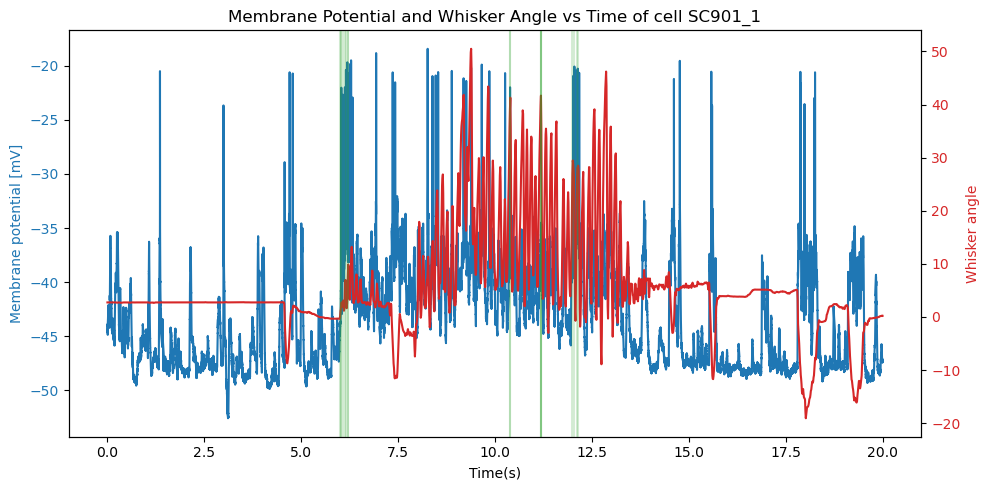

<Figure size 640x480 with 0 Axes>

In [184]:
len_sweep_vm = len(data_df['Sweep_MembranePotential'][0])
Fs_whisker_VM = data_df['Sweep_MembranePotential_SamplingRate'][0]
x_VM=np.linspace(0,len_sweep_vm*1/Fs_whisker_VM,len_sweep_vm)
len_sweep_WP = len(data_df['Sweep_WhiskerAngle'][0])
Fs_whisker_angle = data_df['Sweep_WhiskerAngle_SamplingRate'][0]
x_WP=np.linspace(0,len_sweep_WP*1/Fs_whisker_angle,len_sweep_WP)

fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:blue'
ax1.set_xlabel("Time(s)")
ax1.set_ylabel("Membrane potential [mV]", color=color)
ax1.plot(x_VM,data_df['Sweep_MembranePotential'][0]*1000, color=color) #[mV]
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:red'
ax2=ax1.twinx()
ax2.set_ylabel("Whisker angle", color=color)
ax2.plot(x_WP,data_df['Sweep_WhiskerAngle'][0], color=color)
ax2.tick_params(axis='y', labelcolor=color)

color = 'tab:green'
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][0][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][0][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][1][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][1][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][2][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][2][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][3][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][3][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][4][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][4][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][5][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][5][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][5][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][5][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][6][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][6][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][7][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][7][1], color=color, alpha=0.2)

plt.title('Membrane Potential and Whisker Angle vs Time of cell SC901_1')
fig.tight_layout()
plt.show()

# Save figure
fname = os.path.join(figure_path, 'VmandWhiskerAnglevsTime.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')


Text(0.5, 1.0, 'Membrane Potential and Whisker Angle vs Time (10s-12.5s)')

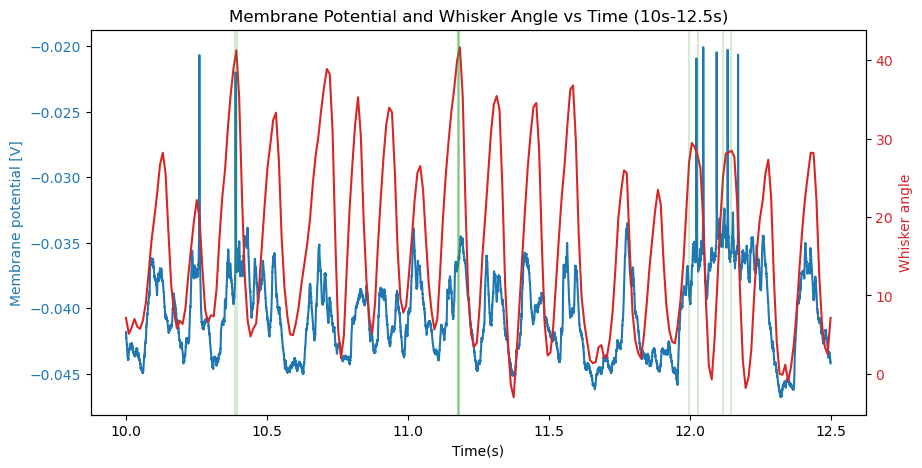

In [185]:
len_WP1= len(data_df['Sweep_WhiskerAngle'][0][1000:1250])
x_WP1=np.linspace(10,12.5,len_WP1)
y_WP1=data_df['Sweep_WhiskerAngle'][0][1000:1250]
len_VM1= len(data_df['Sweep_MembranePotential'][0][200000:250000])
x_VM1=np.linspace(10,12.5,len_VM1)
y_VM1=data_df['Sweep_MembranePotential'][0][200000:250000]


fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:blue'
ax1.set_xlabel("Time(s)")
ax1.set_ylabel("Membrane potential [V]", color=color)
ax1.plot(x_VM1,y_VM1, color=color) #[mV]
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:red'
ax2=ax1.twinx()
ax2.set_ylabel("Whisker angle", color=color)
ax2.plot(x_WP1,y_WP1, color=color)
ax2.tick_params(axis='y', labelcolor=color)

color='tab:green'
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][4][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][4][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][5][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][5][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][5][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][5][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][6][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][6][1], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][7][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][7][1], color=color, alpha=0.2)

plt.title('Membrane Potential and Whisker Angle vs Time (10s-12.5s)')

In [11]:
whisker_angle_0 = data_df['Sweep_WhiskerAngle'][0][0] #whisker angle at the beginning
print(whisker_angle_0)

2.740000000000009


In [12]:
membrane_potential_0 = data_df['Sweep_MembranePotential'][0][0]
print(membrane_potential_0)

-0.044009375


Text(0.5, 1.0, 'Membrane Potential and Whisker Angle vs Time zoomed for one active touch')

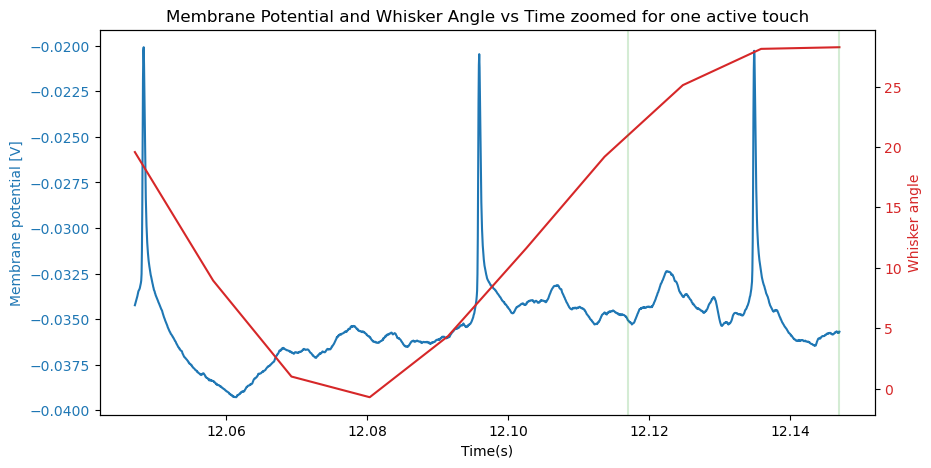

In [186]:
ActiveContactTimes_7_pre= int((data_df['Sweep_ActiveContactTimes'][0][7][1]-0.1)*20000)
ActiveContactTimes_7_post= int((data_df['Sweep_ActiveContactTimes'][0][7][1])*20000)
membrane_potential_AT7 = data_df['Sweep_MembranePotential'][0][ActiveContactTimes_7_pre:ActiveContactTimes_7_post]
len_VM_AT7= len(membrane_potential_AT7)
x_VM_AT7=np.linspace(data_df['Sweep_ActiveContactTimes'][0][7][1]-0.1,data_df['Sweep_ActiveContactTimes'][0][7][1],len_VM_AT7)
y_VM_AT7 = membrane_potential_AT7
ACT_WP_7_pre= int((data_df['Sweep_ActiveContactTimes'][0][7][1]-0.1)*100)
ACT_WP_7_post= int((data_df['Sweep_ActiveContactTimes'][0][7][1])*100)
len_WP_AT7= len(data_df['Sweep_WhiskerAngle'][0][ACT_WP_7_pre:ACT_WP_7_post])
x_WP_AT7=np.linspace(data_df['Sweep_ActiveContactTimes'][0][7][1]-0.1,data_df['Sweep_ActiveContactTimes'][0][7][1],len_WP_AT7)
y_WP_AT7=data_df['Sweep_WhiskerAngle'][0][ACT_WP_7_pre:ACT_WP_7_post]
fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:blue'
ax1.set_xlabel("Time(s)")
ax1.set_ylabel("Membrane potential [V]", color=color)
ax1.plot(x_VM_AT7,y_VM_AT7, color=color) #[mV]
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:red'
ax2=ax1.twinx()
ax2.set_ylabel("Whisker angle", color=color)
ax2.plot(x_WP_AT7,y_WP_AT7, color=color)
ax2.tick_params(axis='y', labelcolor=color)

color='tab:green'
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][7][0], color=color, alpha=0.2)
plt.axvline(x=data_df['Sweep_ActiveContactTimes'][0][7][1], color=color, alpha=0.2)

plt.title('Membrane Potential and Whisker Angle vs Time zoomed for one active touch')

In [14]:
max_WP = max(y_WP_AT7)
min_WP = min(y_WP_AT7)
max_VM = max(y_VM_AT7)
min_VM = min(y_VM_AT7)
print(max_WP)
print(min_WP)
print(max_VM)
print(min_VM)


28.25142229673699
-0.7153919396606057
-0.020078125
-0.039290625


In [15]:
print(data_df['Sweep_ActiveContactTimes'][0][7][1]-0.05)
print(data_df['Sweep_ActiveContactTimes'][0][7][1])


12.097
12.147


In [16]:
#Sweep_ActiveContactTimes

In [17]:
data_df['Sweep_WhiskerAngle_SamplingRate']

0      100.0
1      100.0
2      100.0
3      100.0
4      100.0
       ...  
826    100.0
827    100.0
828    100.0
829    100.0
830    100.0
Name: Sweep_WhiskerAngle_SamplingRate, Length: 831, dtype: float64

In [18]:
print(data_df.columns)

Index(['Cell_APThreshold_Slope', 'Cell_Anatomy', 'Cell_Counter', 'Cell_Depth',
       'Cell_ID', 'Cell_Layer', 'Cell_TargetedBrainArea', 'Cell_Type',
       'Cell_tdTomatoExpressing', 'Mouse_DateOfBirth', 'Mouse_Genotype',
       'Mouse_Name', 'Mouse_Sex', 'Sweep_ActiveContactTimes', 'Sweep_Counter',
       'Sweep_MembranePotential', 'Sweep_MembranePotential_SamplingRate',
       'Sweep_PassiveContactTimes', 'Sweep_QuietTimes', 'Sweep_StartTime',
       'Sweep_Type', 'Sweep_WhiskerAngle', 'Sweep_WhiskerAngle_SamplingRate',
       'Sweep_WhiskingTimes'],
      dtype='object')


In [95]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def VmVsWhiskerAngle (cell_id):
    # Prepare a colormap
    colors = list(mcolors.TABLEAU_COLORS.values())  # Using Tableau colors for distinction
    color_index = 0

    #cell_id = 'SC901_1'
    cell_df = data_df_subset[data_df_subset.Cell_ID==cell_id]
    plt.figure(figsize=(10, 6))
    trial_list = cell_df.Sweep_Counter
    print(trial_list)

    for trial in trial_list:
        trial_data = cell_df[cell_df.Sweep_Counter == trial]

        # Extract necessary data for the trial
        sr_vm = trial_data['Sweep_MembranePotential_SamplingRate'].values[0]
        membrane_potential = trial_data['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = trial_data['Cell_APThreshold_Slope'].values[0]
        whisker_angle = trial_data['Sweep_WhiskerAngle'].values[0]
        active_touch_times = trial_data['Sweep_ActiveContactTimes'].values[0]
        sr_wp = trial_data['Sweep_WhiskerAngle_SamplingRate'].values[0]


        good_active_touch_times = []
        
        for i in range (len(active_touch_times)-1):
            if i == 0:
                good_active_touch_times.append(active_touch_times[i, :])
            elif active_touch_times[i+1][0]-good_active_touch_times[-1][1]>0.2:
                good_active_touch_times.append(active_touch_times[i+1,:])

        good_active_touch_times = np.vstack(good_active_touch_times)
        '''
        for i in range (len(active_touch_times)-1):
            if i == 0:
                good_active_touch_times.append(active_touch_times[i, :])
            elif active_touch_times[i+1][0]-active_touch_times[i][1]>0.2:
                good_active_touch_times.append(active_touch_times[i+1,:])

        good_active_touch_times = np.vstack(good_active_touch_times)
        '''
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)
        ap_peak_times = ap_params[:, 2]
        ap_thresh_times = ap_params[:, 0]   
        vm_subthreshold = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)

        time_vm = np.arange(len(vm_subthreshold)) / sr_vm
        time_whisker = np.arange(len(whisker_angle)) / sr_wp

        # Initialize a list to store min and max Vm for each active touch interval
        min_max_vm_values = []
        delta_vm = []

        # Initialize a list to store min and max WP for each active touch interval
        min_max_wp_values = []
        delta_wp = []

        for start, end in good_active_touch_times:
            # Convert the start and end time of the active touch to indices
            start_index_VM = np.searchsorted(time_vm, start)
            end_index_VM = np.searchsorted(time_vm, end+0.05)
            start_index_WP = np.searchsorted(time_whisker, start-0.05)
            end_index_WP = np.searchsorted(time_whisker, end)

            # Extract the Vm segment for the current interval
            vm_segment = vm_subthreshold[start_index_VM:end_index_VM]
            # Extract the Vm segment for the current interval
            wp_segment = whisker_angle[start_index_WP:end_index_WP]

            # Calculate the minimum and maximum Vm for the segment
            min_vm = np.min(vm_segment)
            max_vm = np.max(vm_segment)
            delta_vm.append(max_vm-min_vm)


            # Calculate the minimum and maximum Vm for the segment
            min_wp = np.min(wp_segment)
            max_wp = np.max(wp_segment)
            delta_wp.append(max_wp-min_wp)

            # Store the results
            min_max_wp_values.append((min_wp, max_wp))

            # min_max_vm_values now contains tuples of (min Vm, max Vm) for each active touch interval

        plt.scatter(delta_wp, delta_vm, color=colors[color_index % len(colors)], label=f'Cell {cell_id}, Trial {trial}')
        color_index += 1

    from scipy.stats import pearsonr
    correlation_coefficient, p_value = pearsonr(delta_wp, delta_vm)
    #plt.title(f'Cell {cell_id}\nPearson\'s correlation coefficient (r): {correlation_coefficient:.2f}, p-value: {p_value:.4f}')


    # Add labels, title, and legend
    plt.ylabel('Vm Amplitude (V)')
    plt.xlabel('Whisker Angle Amplitude (degrees)')
    plt.title(f'Correlation Between Vm Amplitude and Whisker Angle Amplitude Across Trials \nPearson\'s correlation coefficient (r): {correlation_coefficient:.2f}, p-value: {p_value:.4f}' )
    plt.legend()

    # Show plot
    plt.show()


In [96]:
def VmVsWhiskerVelocity(cell_id):
    # Prepare a colormap
    colors = list(mcolors.TABLEAU_COLORS.values())  # Using Tableau colors for distinction
    color_index = 0

    cell_df = data_df_subset[data_df_subset.Cell_ID==cell_id]
    plt.figure(figsize=(10, 6))
    trial_list = cell_df.Sweep_Counter

    for trial in trial_list:
        trial_data = cell_df[cell_df.Sweep_Counter == trial]

        # Extract necessary data for the trial
        sr_vm = trial_data['Sweep_MembranePotential_SamplingRate'].values[0]
        membrane_potential = trial_data['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = trial_data['Cell_APThreshold_Slope'].values[0]
        whisker_angle = trial_data['Sweep_WhiskerAngle'].values[0]
        active_touch_times = trial_data['Sweep_ActiveContactTimes'].values[0]
        sr_wp = trial_data['Sweep_WhiskerAngle_SamplingRate'].values[0]


        good_active_touch_times = []
        
        for i in range (len(active_touch_times)-1):
            if i == 0:
                good_active_touch_times.append(active_touch_times[i, :])
            elif active_touch_times[i+1][0]-good_active_touch_times[-1][1]>0.2:
                good_active_touch_times.append(active_touch_times[i+1,:])

        good_active_touch_times = np.vstack(good_active_touch_times)
        
        '''
        for i in range (len(active_touch_times)-1):
            if i == 0:
                good_active_touch_times.append(active_touch_times[i, :])
            elif active_touch_times[i+1][0]-active_touch_times[i][1]>0.2:
                good_active_touch_times.append(active_touch_times[i+1,:])

        good_active_touch_times = np.vstack(good_active_touch_times)
        '''
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)
        ap_peak_times = ap_params[:, 2]
        ap_thresh_times = ap_params[:, 0]   
        vm_subthreshold = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)

        time_vm = np.arange(len(vm_subthreshold)) / sr_vm
        time_whisker = np.arange(len(whisker_angle)) / sr_wp

        # Initialize a list to store min and max Vm for each active touch interval
        min_max_vm_values = []
        delta_vm = []

        # Initialize a list to store min and max WP for each active touch interval
        min_max_wp_values = []
        delta_wp = []
        velocity_wp = []

        for start, end in good_active_touch_times:
            # Convert the start and end time of the active touch to indices
            start_index_VM = np.searchsorted(time_vm, start)
            end_index_VM = np.searchsorted(time_vm, end+0.05)
            start_index_WP = np.searchsorted(time_whisker, start-0.05)
            end_index_WP = np.searchsorted(time_whisker, end)

            # Extract the Vm segment for the current interval
            vm_segment = vm_subthreshold[start_index_VM:end_index_VM]
            # Extract the Vm segment for the current interval
            wp_segment = whisker_angle[start_index_WP:end_index_WP]

            # Calculate the minimum and maximum Vm for the segment
            min_vm = np.min(vm_segment)
            max_vm = np.max(vm_segment)
            delta_vm.append(max_vm-min_vm)


            # Calculate the minimum and maximum Vm for the segment
            min_wp = np.min(wp_segment)
            max_wp = np.max(wp_segment)
            delta_wp.append(max_wp-min_wp)
            velocity_wp.append((whisker_angle[end_index_WP]-whisker_angle[start_index_WP])/0.05)

            # Store the results
            min_max_wp_values.append((min_wp, max_wp))

            # min_max_vm_values now contains tuples of (min Vm, max Vm) for each active touch interval

        plt.scatter(velocity_wp, delta_vm, color=colors[color_index % len(colors)], label=f'Cell {cell_id}, Trial {trial}')
        color_index += 1

    from scipy.stats import pearsonr
    correlation_coefficient, p_value = pearsonr(velocity_wp, delta_vm)

    # Add labels, title, and legend
    plt.ylabel('Vm Amplitude (V)')
    plt.xlabel('Velocity Whisker Angle (degree/s)')
    plt.title(f'Correlation Between Vm Amplitude and Whisker Angle Amplitude Across Trials \nPearson\'s correlation coefficient (r): {correlation_coefficient:.2f}, p-value: {p_value:.4f}')
    plt.legend()

    # Show plot
    plt.show()

In [108]:
#import numpy as np
#import matplotlib.pyplot as plt
#from scipy.optimize import curve_fit
#from matplotlib import colors as mcolors

#def log_shape_function(x, a, b, c):
 #   return a * np.log(b * x) + c

def deltaVmVsICI(cell_id):

    # Prepare a colormap
    colors = list(mcolors.TABLEAU_COLORS.values())  # Using Tableau colors for distinction
    color_index = 0

    cell_df = data_df_subset[data_df_subset.Cell_ID==cell_id]
    plt.figure(figsize=(10, 6))
    trial_list = cell_df.Sweep_Counter


    for trial in trial_list:
        trial_data = cell_df[cell_df.Sweep_Counter == trial]

        # Extract necessary data for the trial
        sr_vm = trial_data['Sweep_MembranePotential_SamplingRate'].values[0]
        membrane_potential = trial_data['Sweep_MembranePotential'].values[0]
        #ap_vm_deriv_thresh = trial_data['Cell_APThreshold_Slope'].values[0]
        whisker_angle = trial_data['Sweep_WhiskerAngle'].values[0]
        active_touch_times = trial_data['Sweep_ActiveContactTimes'].values[0]
        sr_wp = trial_data['Sweep_WhiskerAngle_SamplingRate'].values[0]
        

        active_touch_times_diff = []
        diff_vm = []
        for i in range (len(active_touch_times)-1):
            if active_touch_times[i+1][0]-active_touch_times[i][1]<1: 
                active_touch_times_diff.append(active_touch_times[i+1][0]-active_touch_times[i][1])
                test=membrane_potential[int(active_touch_times[i][1]*20000):int(active_touch_times[i+1][0]*20000)]
                diff_vm.append(max(test)-min(test))
        active_touch_times_diff = np.vstack(active_touch_times_diff)

        #plt.scatter(active_touch_times_diff, diff_vm, color=colors[color_index % len(colors)], label=f'Cell {cell_id}, Trial {trial}')
        plt.scatter(active_touch_times_diff, diff_vm, color=colors[color_index % len(colors)], label=f'Cell {cell_id}, Trial {trial}')

        # Fit a log-shaped line to the data
        #popt, pcov = curve_fit(log_shape_function, active_touch_times_diff.flatten(), diff_vm)

        # Plot the fitted curve
        #x_fit = np.linspace(min(active_touch_times_diff), max(active_touch_times_diff), 100)
        #y_fit = log_shape_function(x_fit, *popt)
        #plt.plot(x_fit, y_fit, color=colors[color_index % len(colors)], linestyle='--', label=f'Log-shaped Fit')

        color_index += 1


    # Add labels, title, and legend
    #plt.xscale('log')
    plt.ylabel('Delta Vm (V)')
    plt.xlabel('Intercontact intervals (sec)')
    plt.title(f'Correlation Between the difference Vm and Intercontact intervals Across Trials')
    plt.legend()

    # Show plot
    plt.show()

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib import colors as mcolors

def log_shape_function(x, a, b, c):
    return a * np.log(b * x) + c

def deltaVmVsICI3(cell_id):
    # Prepare a colormap
    colors = list(mcolors.TABLEAU_COLORS.values())  # Using Tableau colors for distinction
    color_index = 0

    cell_df = data_df_subset[data_df_subset.Cell_ID == cell_id]

    trial_list = cell_df.Sweep_Counter

    active_touch_times_diff_all = []
    diff_vm_all = []
    plt.figure(figsize=(10, 6))

    for trial in trial_list:
        trial_data = cell_df[cell_df.Sweep_Counter == trial]

        # Extract necessary data for the trial
        active_touch_times = trial_data['Sweep_ActiveContactTimes'].values[0]
        membrane_potential = trial_data['Sweep_MembranePotential'].values[0]

        active_touch_times_diff = []
        diff_vm = []
        for i in range(len(active_touch_times) - 1):
            if active_touch_times[i + 1][0] - active_touch_times[i][1] < 1:
                active_touch_times_diff.append(active_touch_times[i + 1][0] - active_touch_times[i][1])
                test = membrane_potential[int(active_touch_times[i][1] * 20000):int(active_touch_times[i + 1][0] * 20000)]
                diff_vm.append(max(test) - min(test))

        active_touch_times_diff_all.extend(active_touch_times_diff)
        diff_vm_all.extend(diff_vm)

        active_touch_times_diff_all_np = np.array(active_touch_times_diff_all).flatten()

        # Scatter plot for each trial with a different color
        plt.scatter(active_touch_times_diff, diff_vm, color=colors[color_index % len(colors)], label=f'Cell {cell_id}, Trial {trial}')

        color_index += 1

    # Fit a single log-shaped line to the combined data
    popt, pcov = curve_fit(log_shape_function, active_touch_times_diff_all_np, diff_vm_all)

    # Plot the fitted curve
    x_fit = np.linspace(min(active_touch_times_diff_all_np), max(active_touch_times_diff_all_np), 100)
    y_fit = log_shape_function(x_fit, *popt)
    plt.plot(x_fit, y_fit, color='black', linestyle='--', label=f'Log-shaped Fit')

    # Add labels, title, and legend
    plt.ylabel('Delta Vm (V)')
    plt.xlabel('Intercontact intervals (sec)')
    plt.title(f'Correlation Between the difference Vm and Intercontact intervals Across Trials')
    plt.legend()

    # Show plot
    plt.show()


0    EXC
1    EXC
3    EXC
4    EXC
5    EXC
Name: Cell_Type, dtype: object
0    1.0
1    2.0
3    4.0
4    5.0
5    6.0
Name: Sweep_Counter, dtype: float64


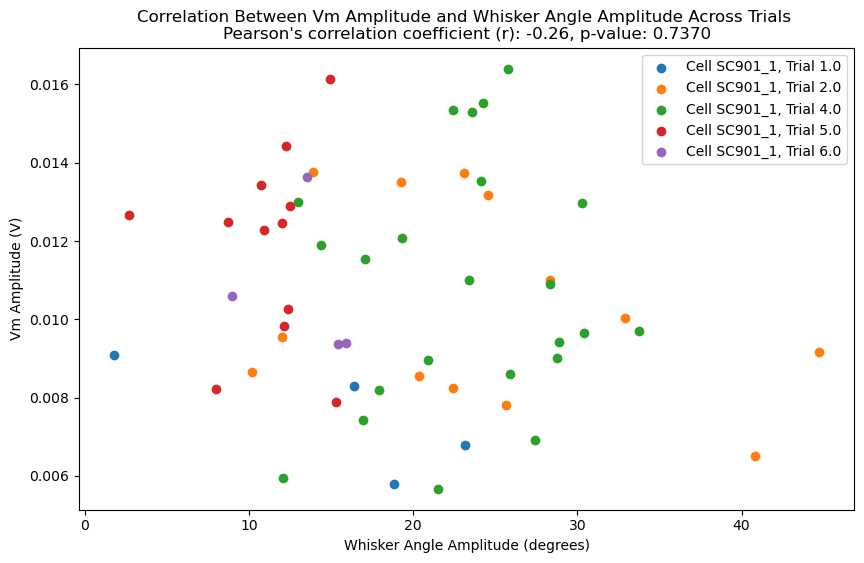

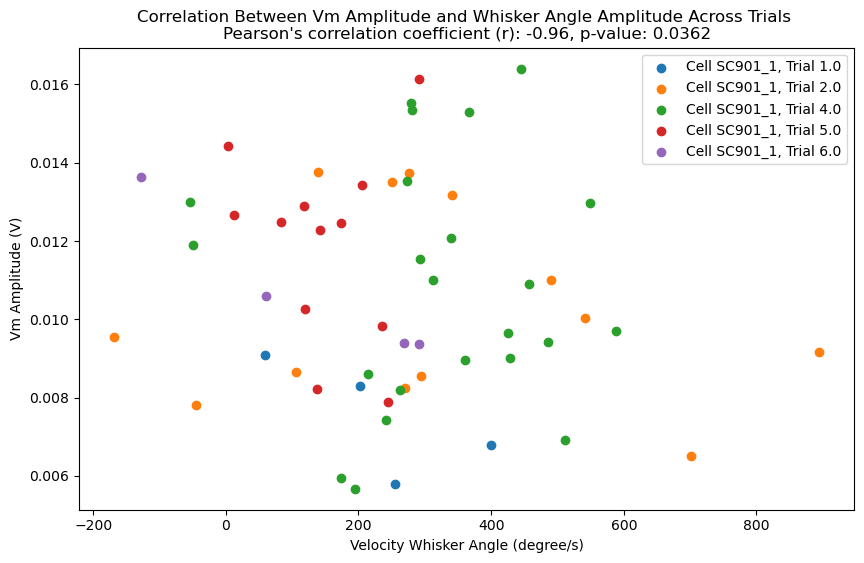

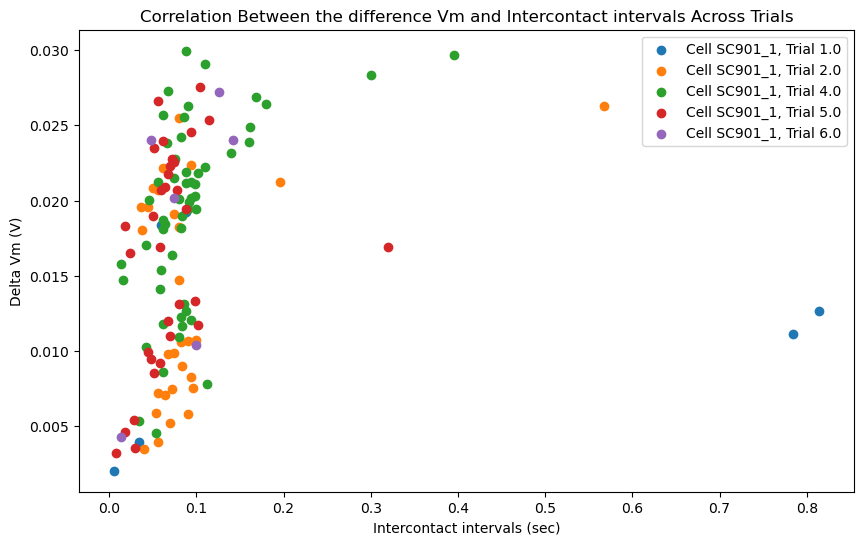

C:\Users\angel\AppData\Local\Temp\ipykernel_18876\3811741178.py:7: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


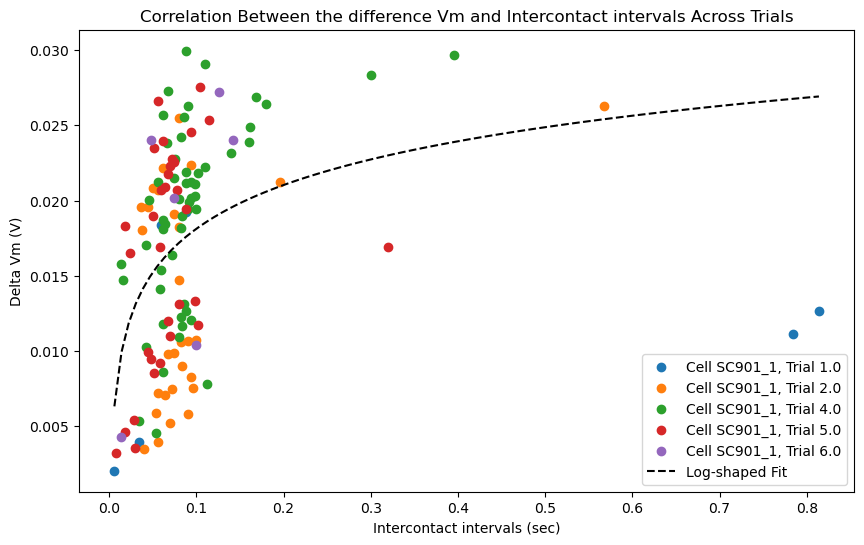

In [152]:
print(data_df_subset[data_df_subset.Cell_ID == 'SC901_1'].Cell_Type)
VmVsWhiskerAngle('SC901_1')
VmVsWhiskerVelocity('SC901_1')
deltaVmVsICI('SC901_1')
deltaVmVsICI3('SC901_1')

print(data_df_subset[data_df_subset.Cell_ID == 'SC926_1'].Cell_Type)
VmVsWhiskerAngle('SC926_1')
VmVsWhiskerVelocity('SC926_1')
deltaVmVsICI('SC926_1')
deltaVmVsICI3('SC926_1')

print(data_df_subset[data_df_subset.Cell_ID == 'SC911_1'].Cell_Type)
VmVsWhiskerAngle('SC911_1')
VmVsWhiskerVelocity('SC911_1')
deltaVmVsICI('SC911_1')
deltaVmVsICI3('SC911_1')

print(data_df_subset[data_df_subset.Cell_ID == 'TK539_2'].Cell_Type)
VmVsWhiskerAngle('TK539_2')
VmVsWhiskerVelocity('TK539_2')
deltaVmVsICI('TK539_2')
deltaVmVsICI3('TK539_2')

154    EXC
155    EXC
159    EXC
Name: Cell_Type, dtype: object
154     5.0
155     6.0
159    10.0
Name: Sweep_Counter, dtype: float64


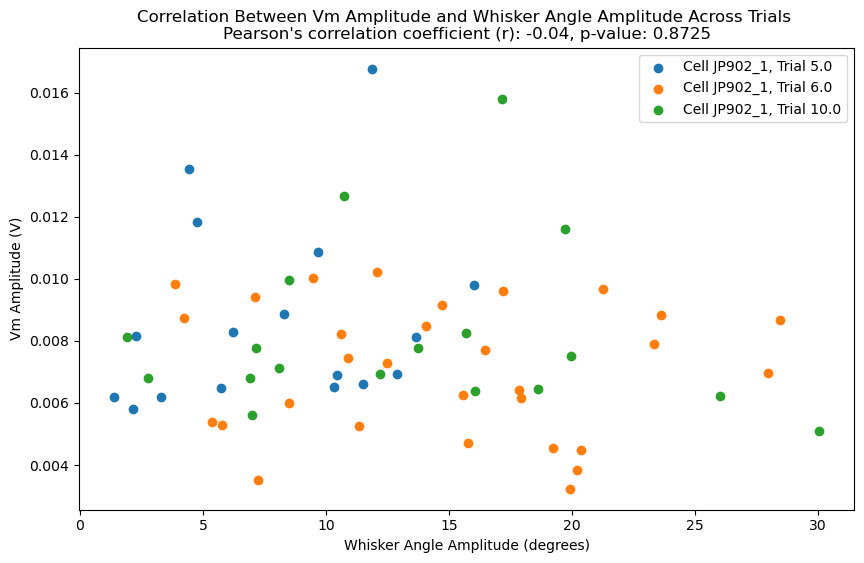

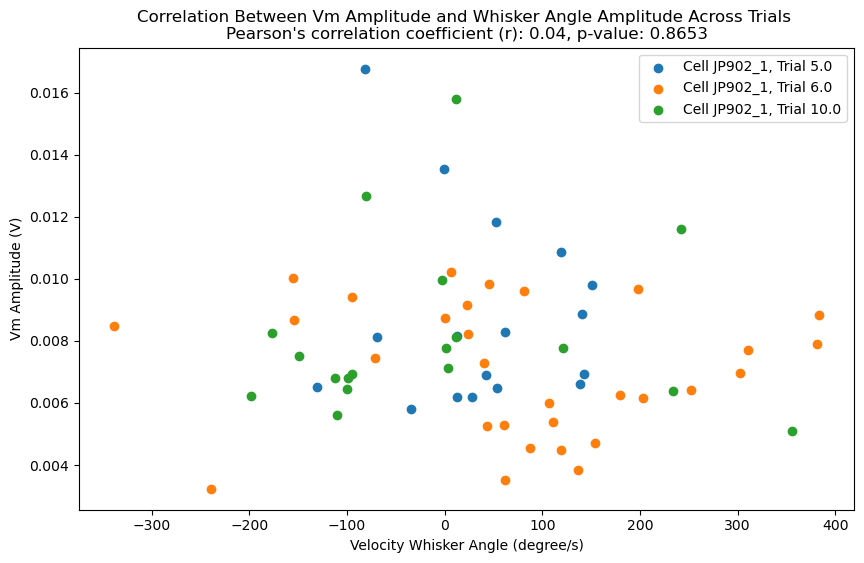

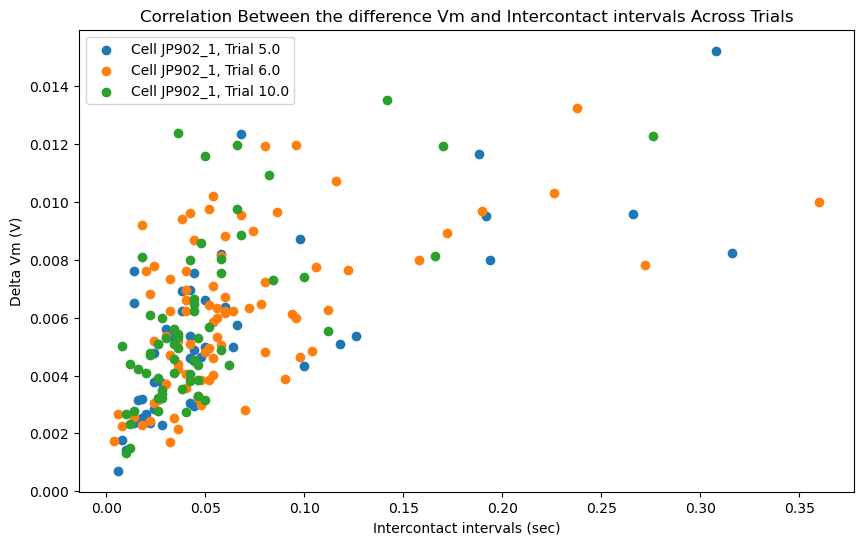

C:\Users\angel\AppData\Local\Temp\ipykernel_18876\3811741178.py:7: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


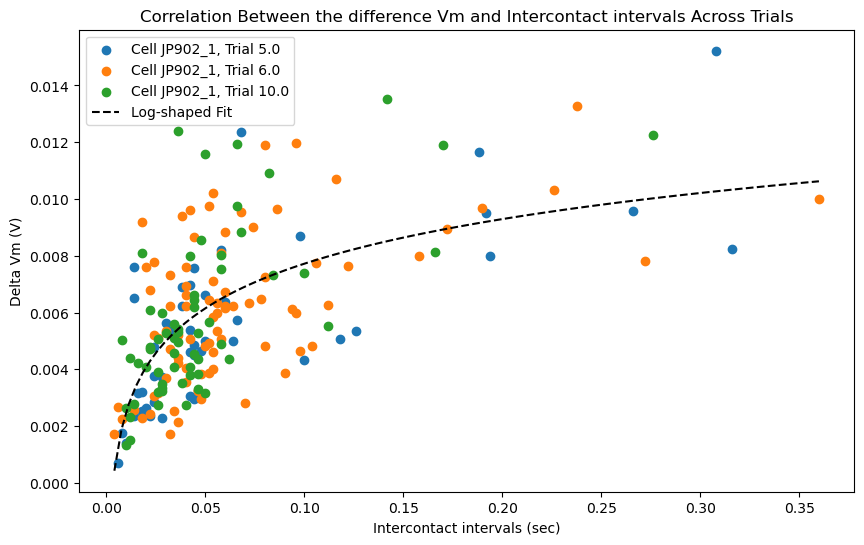

In [156]:
print(data_df_subset[data_df_subset.Cell_ID == 'JP902_1'].Cell_Type)
VmVsWhiskerAngle('JP902_1')
VmVsWhiskerVelocity('JP902_1')
deltaVmVsICI('JP902_1')
deltaVmVsICI3('JP902_1')

130    EXC
131    EXC
132    EXC
134    EXC
135    EXC
136    EXC
137    EXC
138    EXC
139    EXC
140    EXC
Name: Cell_Type, dtype: object
130     1.0
131     2.0
132     3.0
134     5.0
135     6.0
136     7.0
137     8.0
138     9.0
139    10.0
140    11.0
Name: Sweep_Counter, dtype: float64


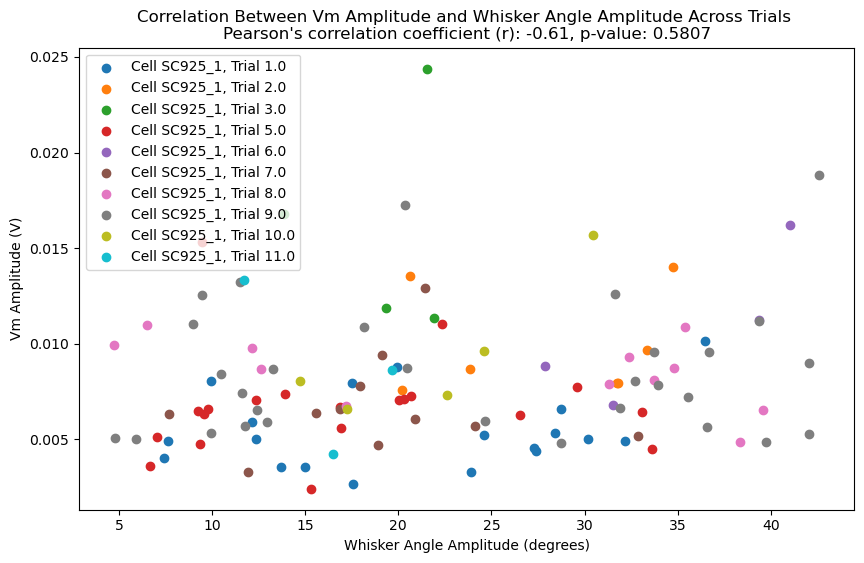

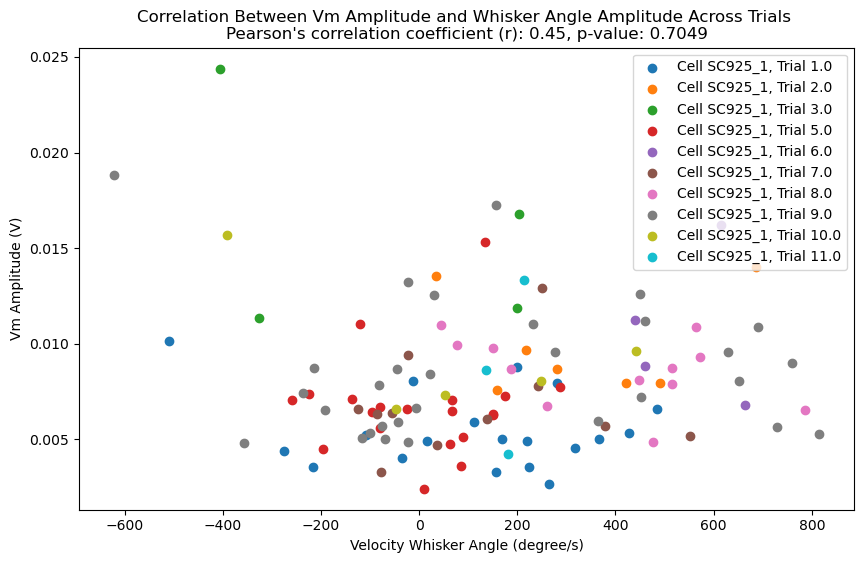

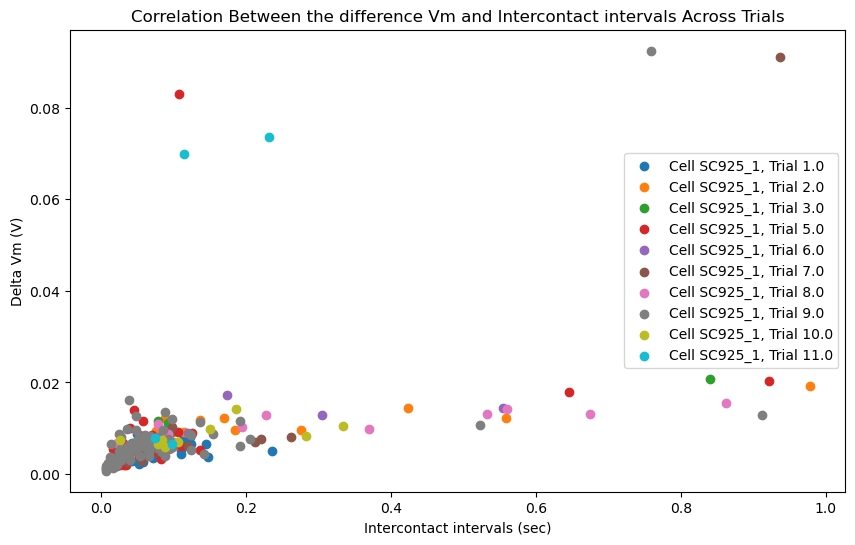

C:\Users\angel\AppData\Local\Temp\ipykernel_18876\3811741178.py:7: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


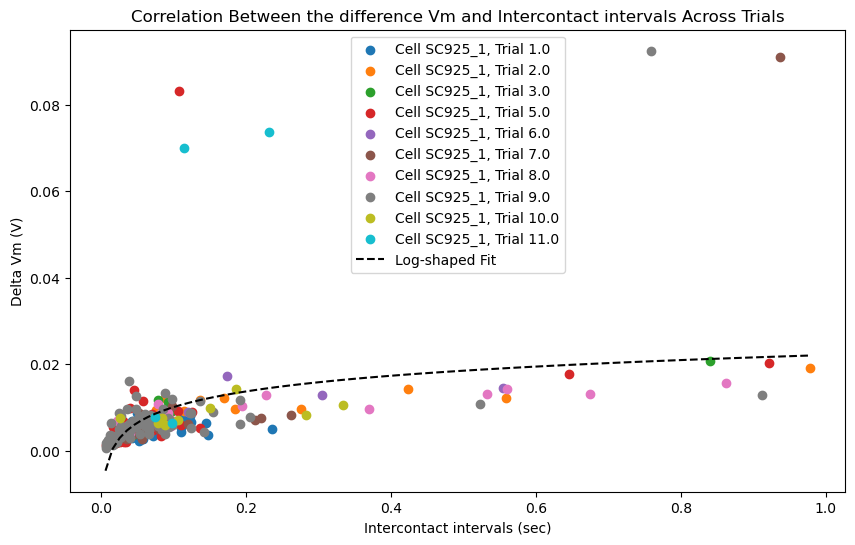

In [188]:
print(data_df_subset[data_df_subset.Cell_ID == 'SC925_1'].Cell_Type)
VmVsWhiskerAngle('SC925_1')
VmVsWhiskerVelocity('SC925_1')
deltaVmVsICI('SC925_1')
deltaVmVsICI3('SC925_1')

print(data_df_subset[data_df_subset.Cell_ID == 'TK494_2'].Cell_Type)
VmVsWhiskerAngle('TK494_2')
VmVsWhiskerVelocity('TK494_2')
deltaVmVsICI('TK494_2')
deltaVmVsICI3('TK494_2')

print(data_df_subset[data_df_subset.Cell_ID == 'TK512_1'].Cell_Type)
VmVsWhiskerAngle('TK512_1')
VmVsWhiskerVelocity('TK512_1')
deltaVmVsICI('TK512_1')
deltaVmVsICI3('TK512_1')

print(data_df_subset[data_df_subset.Cell_ID == 'TK177_1'].Cell_Type)
VmVsWhiskerAngle('TK177_1')
VmVsWhiskerVelocity('TK177_1')
deltaVmVsICI('TK177_1')
deltaVmVsICI3('TK177_1')

print(data_df_subset[data_df_subset.Cell_ID == 'TK320_1'].Cell_Type)
VmVsWhiskerAngle('TK320_1')
VmVsWhiskerVelocity('TK320_1')
deltaVmVsICI('TK320_1')
deltaVmVsICI3('TK320_1')

print(data_df_subset[data_df_subset.Cell_ID == 'TK320_2'].Cell_Type)
VmVsWhiskerAngle('TK320_2')
VmVsWhiskerVelocity('TK320_2')
deltaVmVsICI('TK320_2')
deltaVmVsICI3('TK320_2')

print(data_df_subset[data_df_subset.Cell_ID == 'TK323_1'].Cell_Type)
VmVsWhiskerAngle('TK323_1')
VmVsWhiskerVelocity('TK323_1')
deltaVmVsICI('TK323_1')
deltaVmVsICI3('TK323_1')

print(data_df_subset[data_df_subset.Cell_ID == 'TK506_3'].Cell_Type)
VmVsWhiskerAngle('TK506_3')
VmVsWhiskerVelocity('TK506_3')
deltaVmVsICI('TK506_3')
deltaVmVsICI3('TK506_3')

print(data_df_subset[data_df_subset.Cell_ID == 'TK516_1'].Cell_Type)
VmVsWhiskerAngle('TK516_1')
VmVsWhiskerVelocity('TK516_1')
deltaVmVsICI('TK516_1')
deltaVmVsICI3('TK516_1')

print(data_df_subset[data_df_subset.Cell_ID == 'TK516_2'].Cell_Type)
VmVsWhiskerAngle('TK516_2')
VmVsWhiskerVelocity('TK516_2')
deltaVmVsICI('TK516_2')
deltaVmVsICI3('TK516_2')

303    PV
304    PV
Name: Cell_Type, dtype: object
303    1.0
304    2.0
Name: Sweep_Counter, dtype: float64


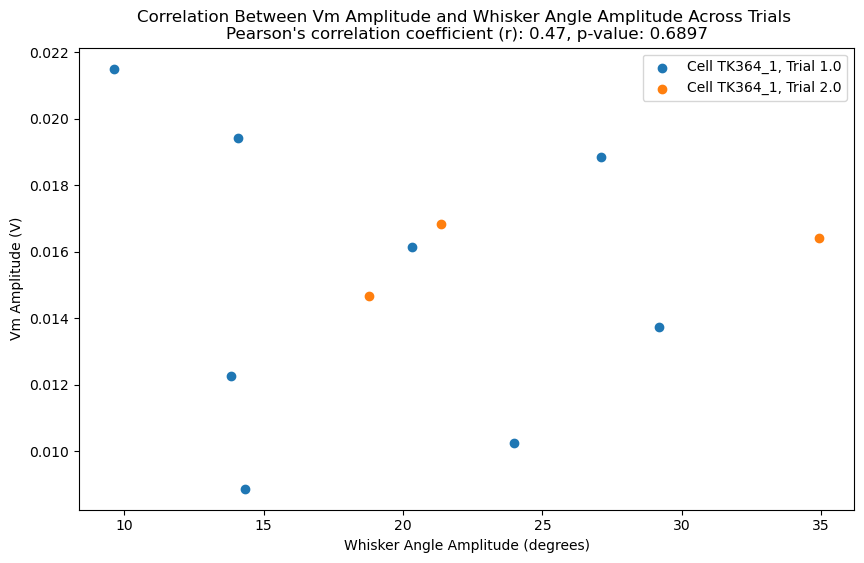

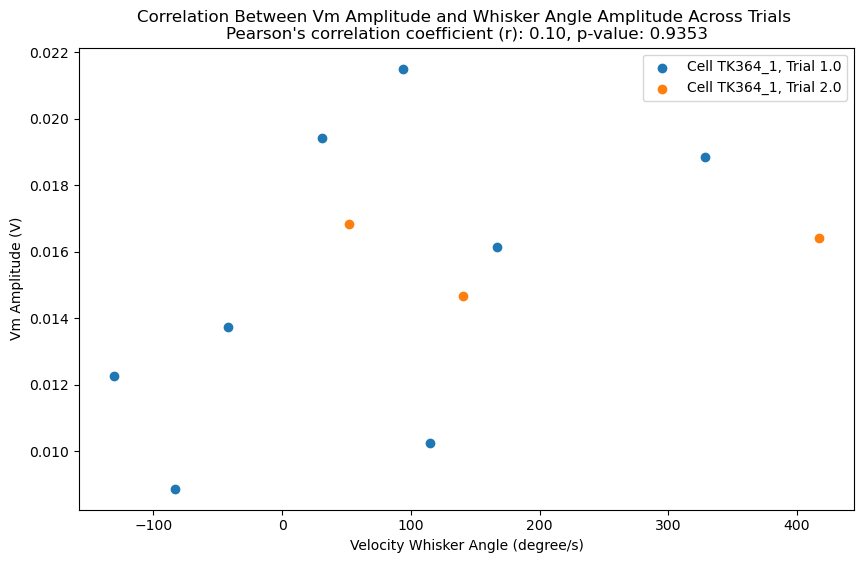

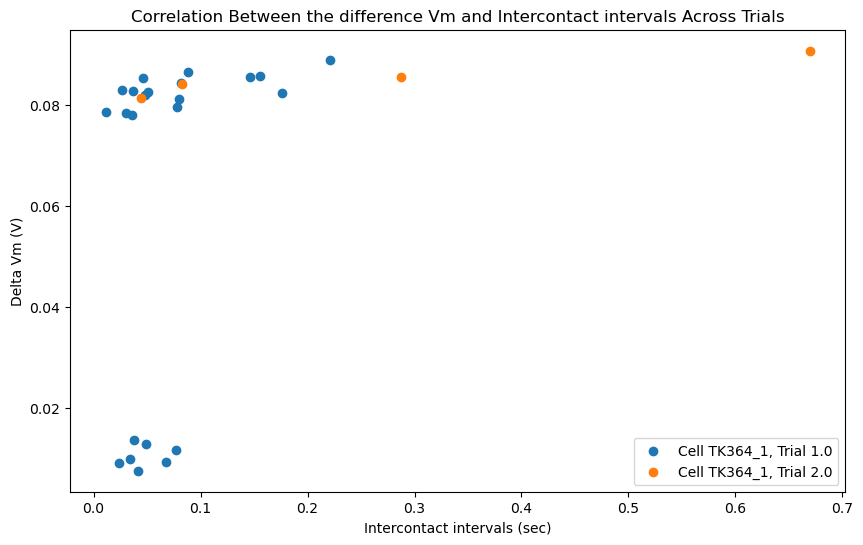

C:\Users\angel\AppData\Local\Temp\ipykernel_18876\3811741178.py:7: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


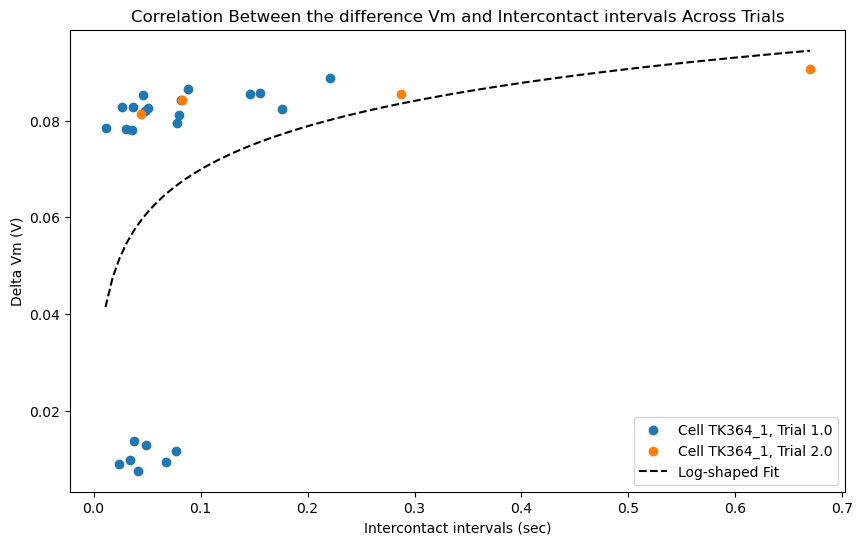

In [190]:
print(data_df_subset[data_df_subset.Cell_ID == 'TK364_1'].Cell_Type)
VmVsWhiskerAngle('TK364_1')
VmVsWhiskerVelocity('TK364_1')
deltaVmVsICI('TK364_1')
deltaVmVsICI3('TK364_1')

341    PV
342    PV
Name: Cell_Type, dtype: object
341    1.0
342    2.0
Name: Sweep_Counter, dtype: float64


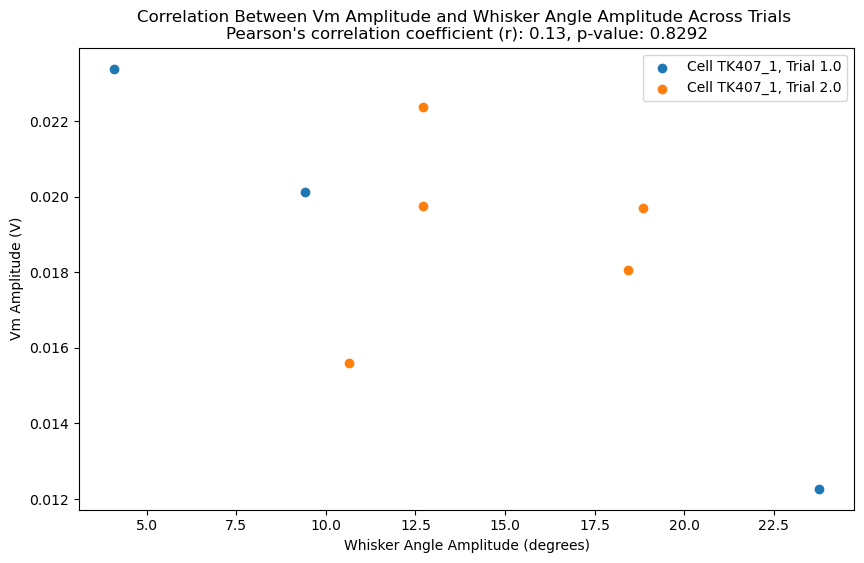

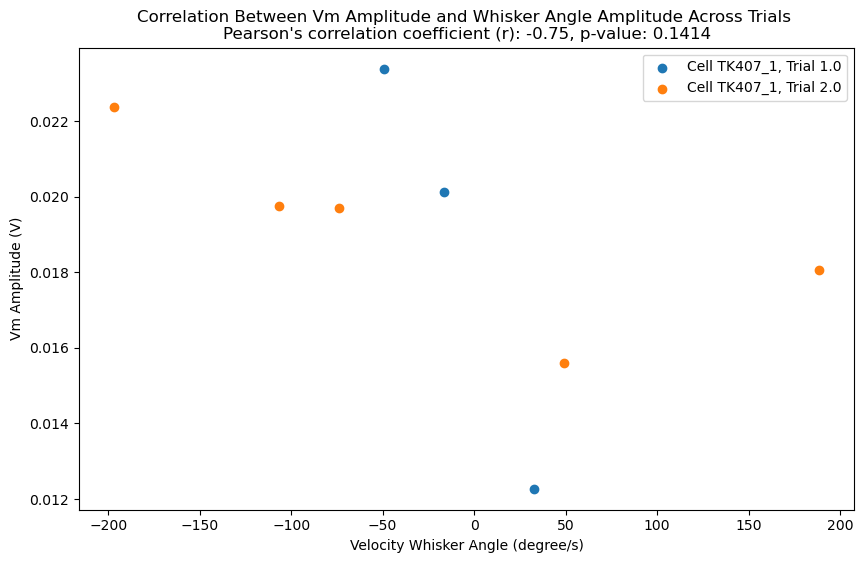

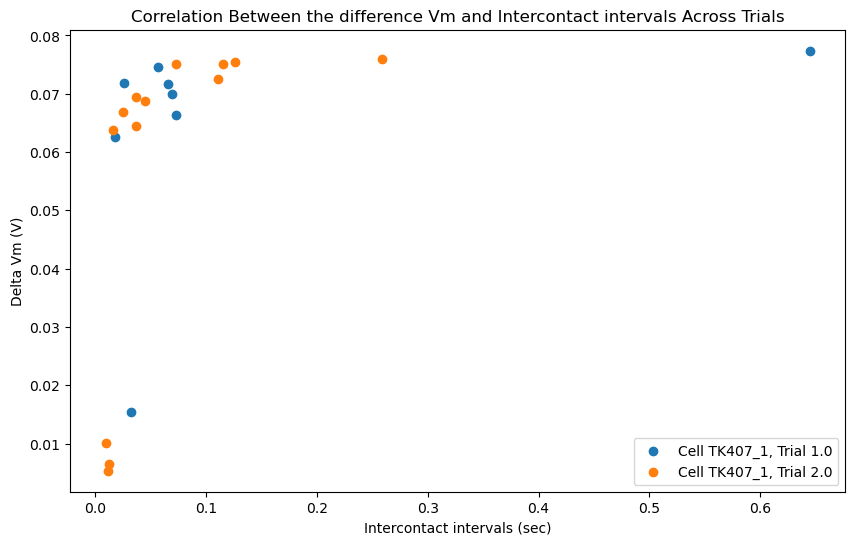

C:\Users\angel\AppData\Local\Temp\ipykernel_18876\3811741178.py:7: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


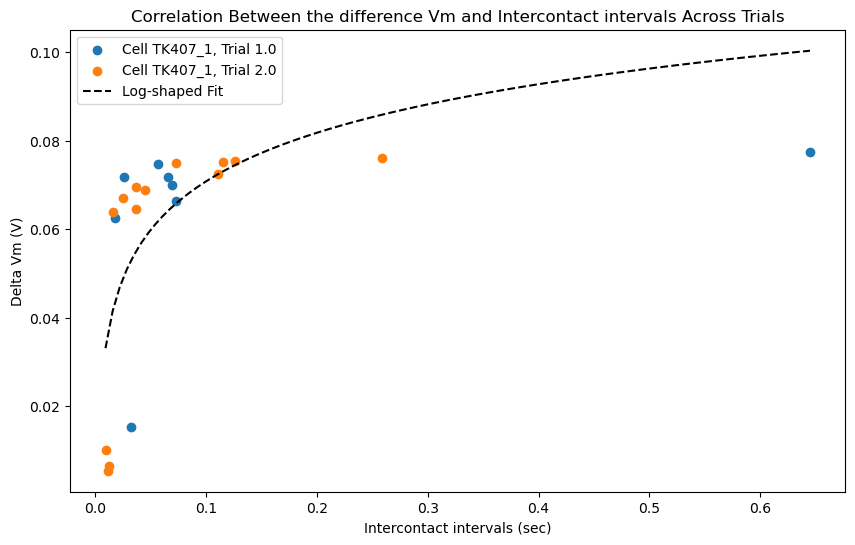

In [191]:
print(data_df_subset[data_df_subset.Cell_ID == 'TK407_1'].Cell_Type)
VmVsWhiskerAngle('TK407_1')
VmVsWhiskerVelocity('TK407_1')
deltaVmVsICI('TK407_1')
deltaVmVsICI3('TK407_1')

354    PV
Name: Cell_Type, dtype: object
354    1.0
Name: Sweep_Counter, dtype: float64


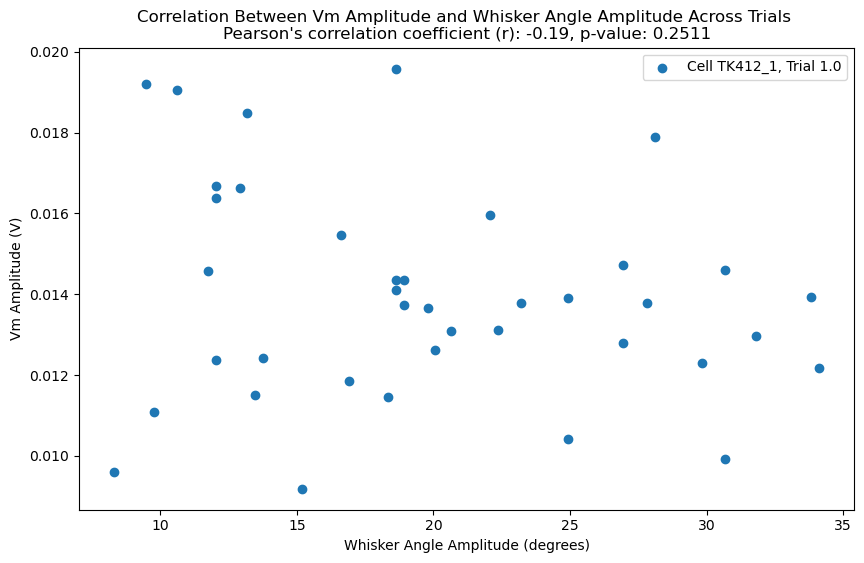

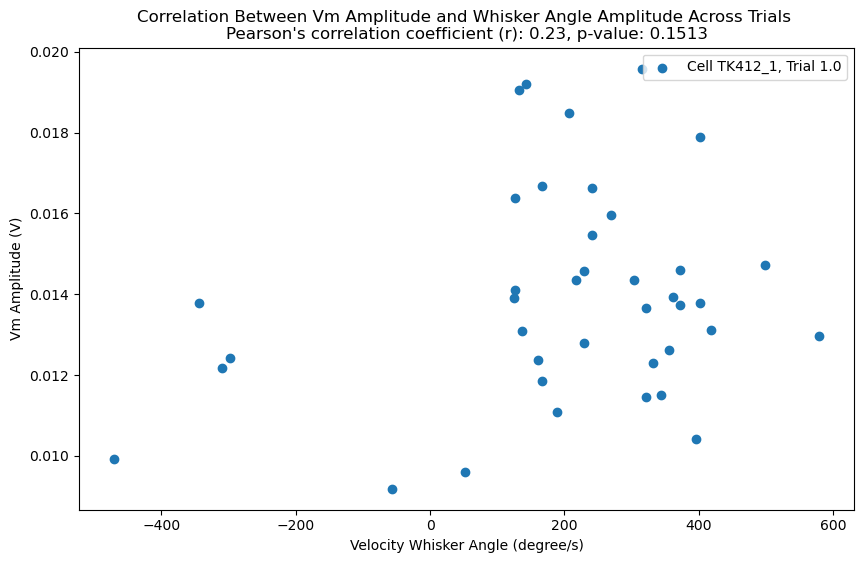

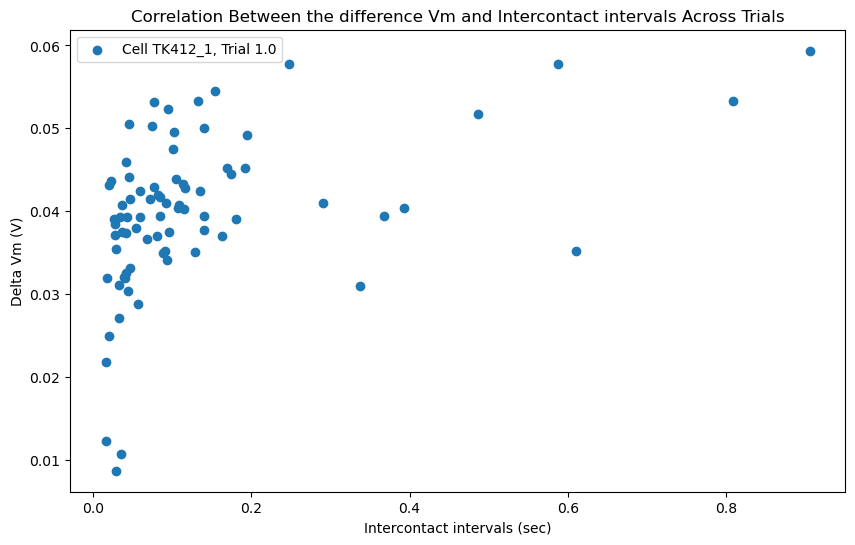

C:\Users\angel\AppData\Local\Temp\ipykernel_18876\3811741178.py:7: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


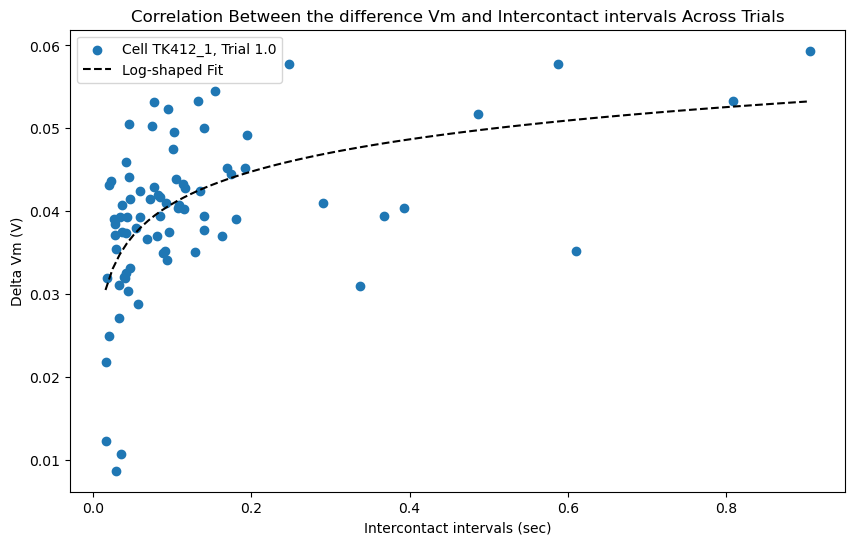

In [193]:
print(data_df_subset[data_df_subset.Cell_ID == 'TK412_1'].Cell_Type)
VmVsWhiskerAngle('TK412_1')
VmVsWhiskerVelocity('TK412_1')
deltaVmVsICI('TK412_1')
deltaVmVsICI3('TK412_1')

373    PV
Name: Cell_Type, dtype: object
373    1.0
Name: Sweep_Counter, dtype: float64


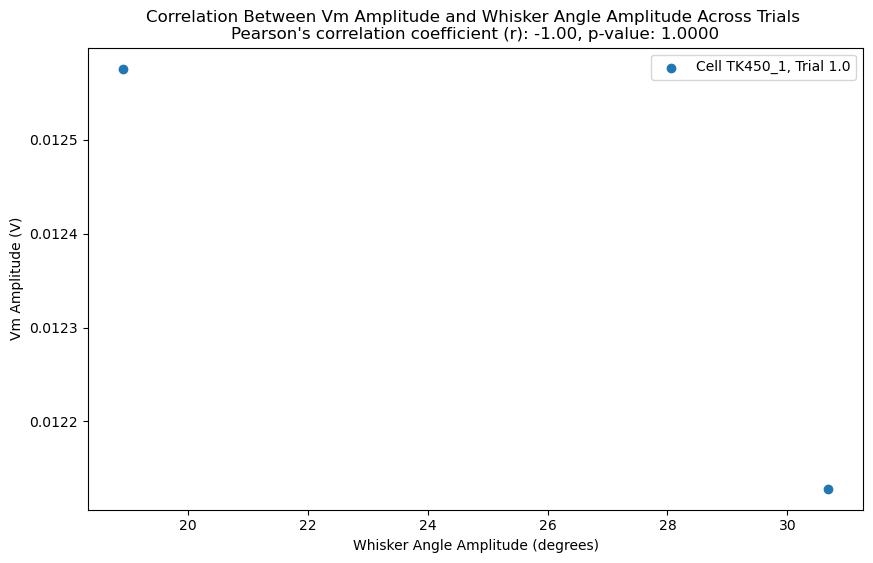

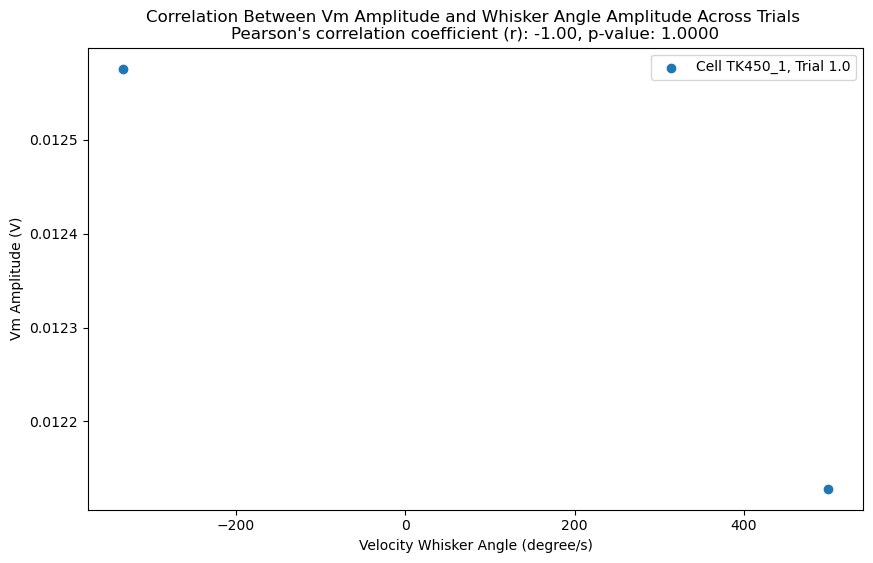

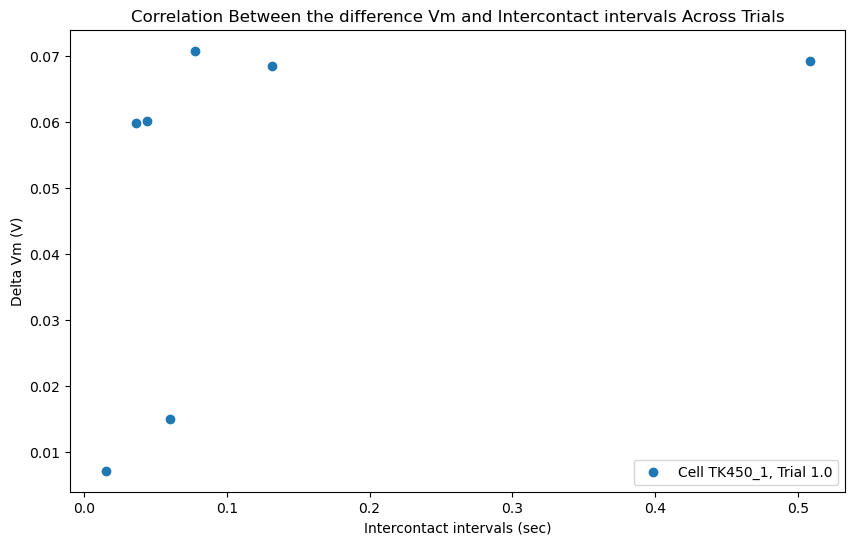

C:\Users\angel\AppData\Local\Temp\ipykernel_18876\3811741178.py:7: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


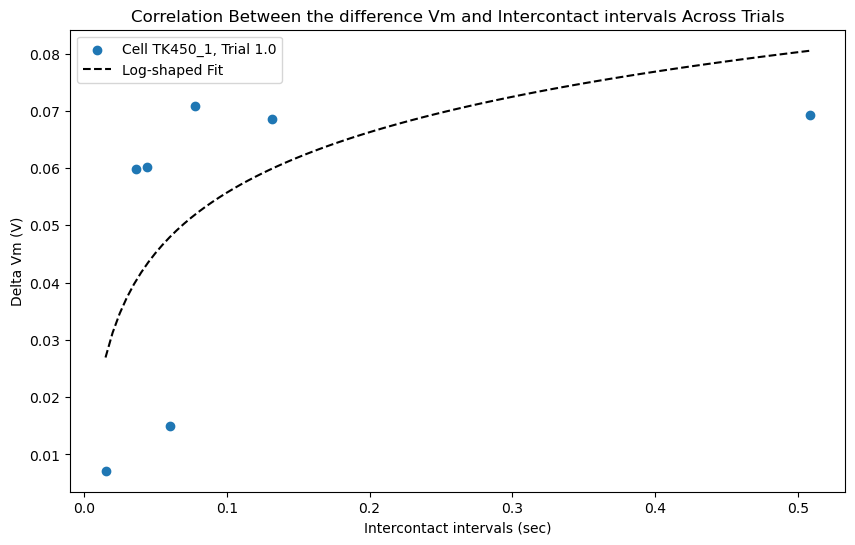

In [194]:
print(data_df_subset[data_df_subset.Cell_ID == 'TK450_1'].Cell_Type)
VmVsWhiskerAngle('TK450_1')
VmVsWhiskerVelocity('TK450_1')
deltaVmVsICI('TK450_1')
deltaVmVsICI3('TK450_1')

430    PV
431    PV
Name: Cell_Type, dtype: object
430    1.0
431    2.0
Name: Sweep_Counter, dtype: float64


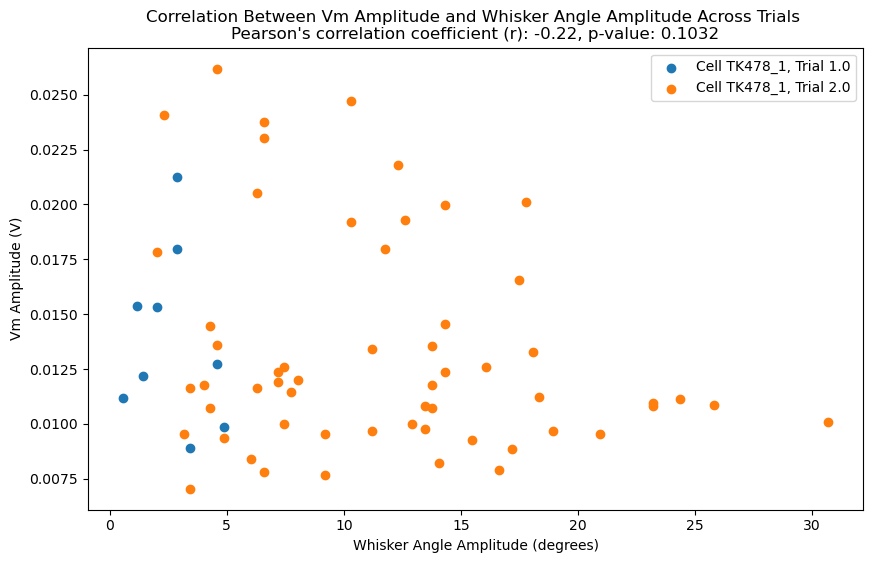

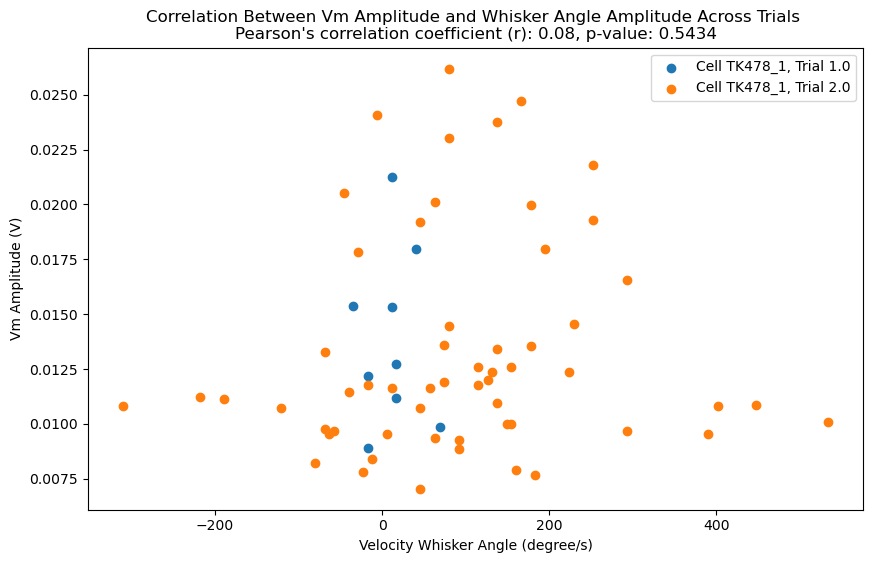

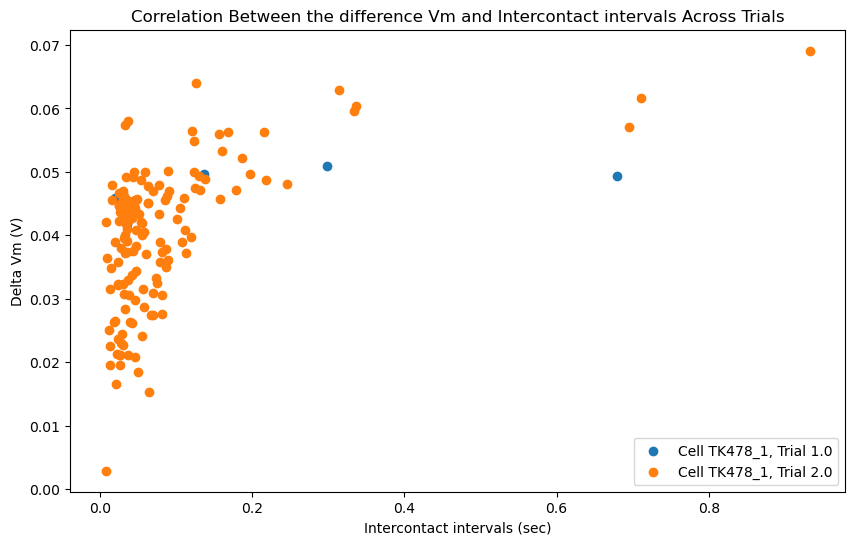

C:\Users\angel\AppData\Local\Temp\ipykernel_18876\3811741178.py:7: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


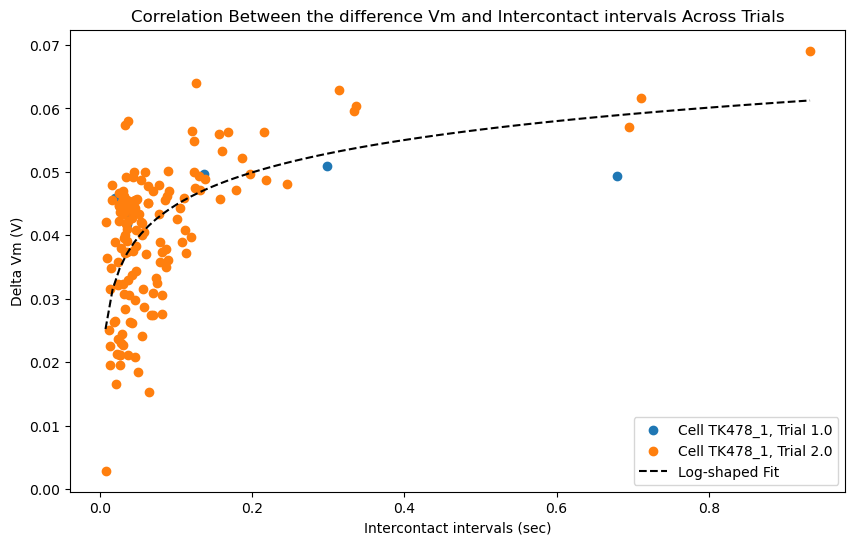

In [195]:
print(data_df_subset[data_df_subset.Cell_ID == 'TK478_1'].Cell_Type)
VmVsWhiskerAngle('TK478_1')
VmVsWhiskerVelocity('TK478_1')
deltaVmVsICI('TK478_1')
deltaVmVsICI3('TK478_1')

593    PV
Name: Cell_Type, dtype: object
593    1.0
Name: Sweep_Counter, dtype: float64


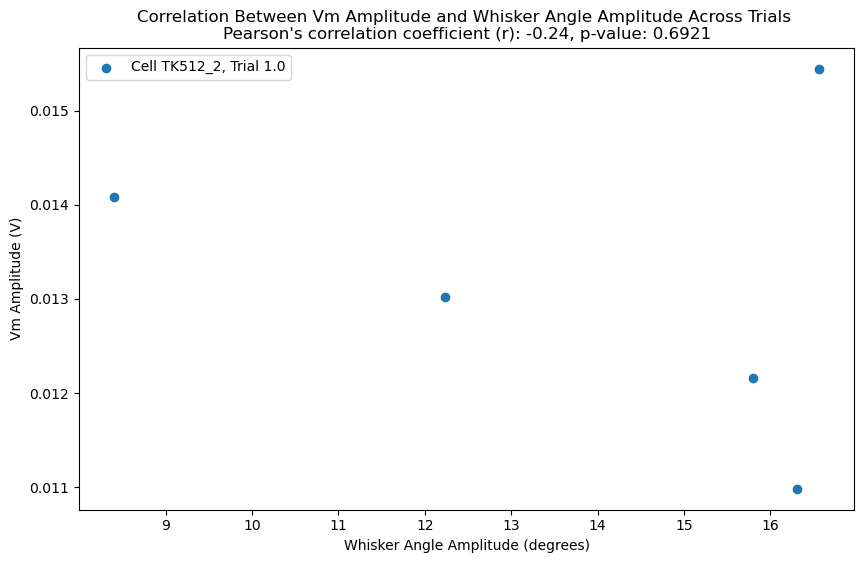

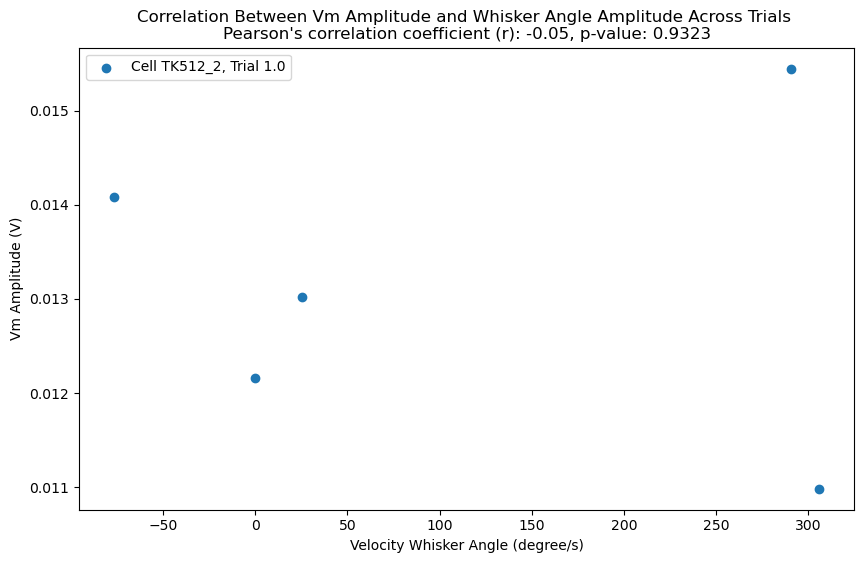

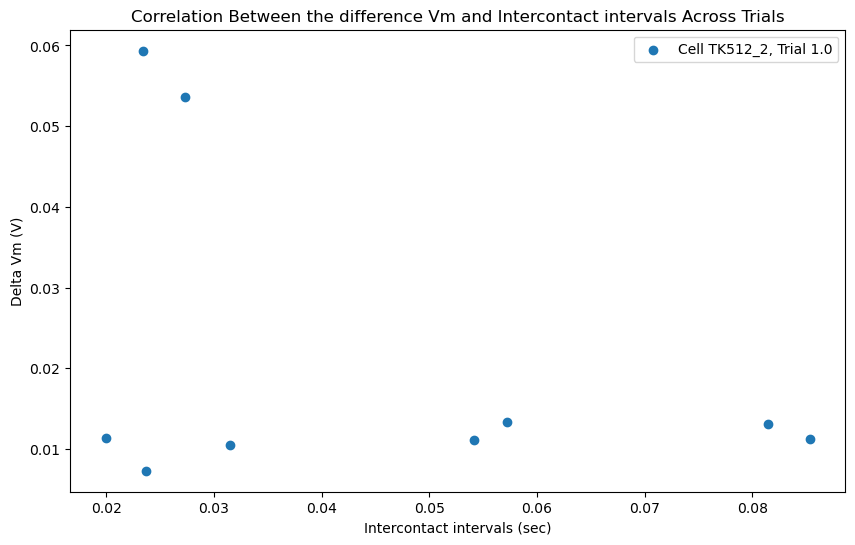

C:\Users\angel\AppData\Local\Temp\ipykernel_18876\3811741178.py:7: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


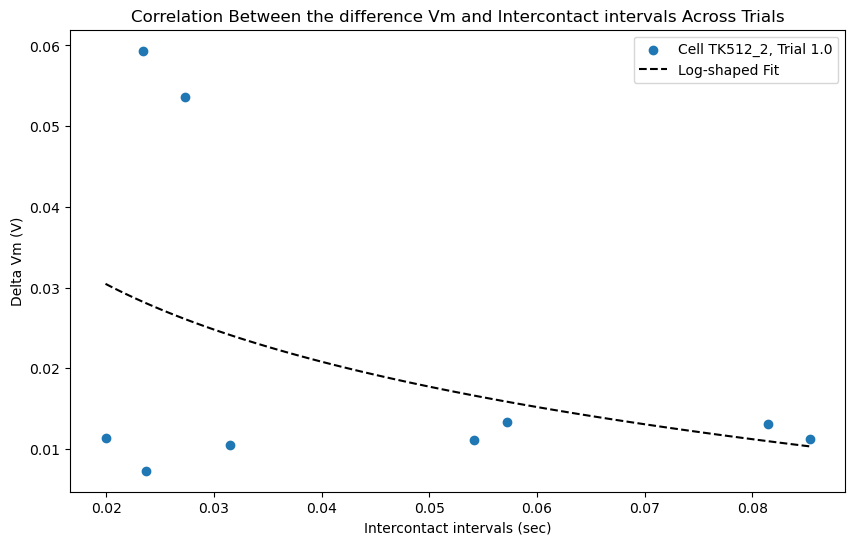

In [196]:
print(data_df_subset[data_df_subset.Cell_ID == 'TK512_2'].Cell_Type)
VmVsWhiskerAngle('TK512_2')
VmVsWhiskerVelocity('TK512_2')
deltaVmVsICI('TK512_2')
deltaVmVsICI3('TK512_2')

586    PV
587    PV
Name: Cell_Type, dtype: object
586    1.0
587    2.0
Name: Sweep_Counter, dtype: float64


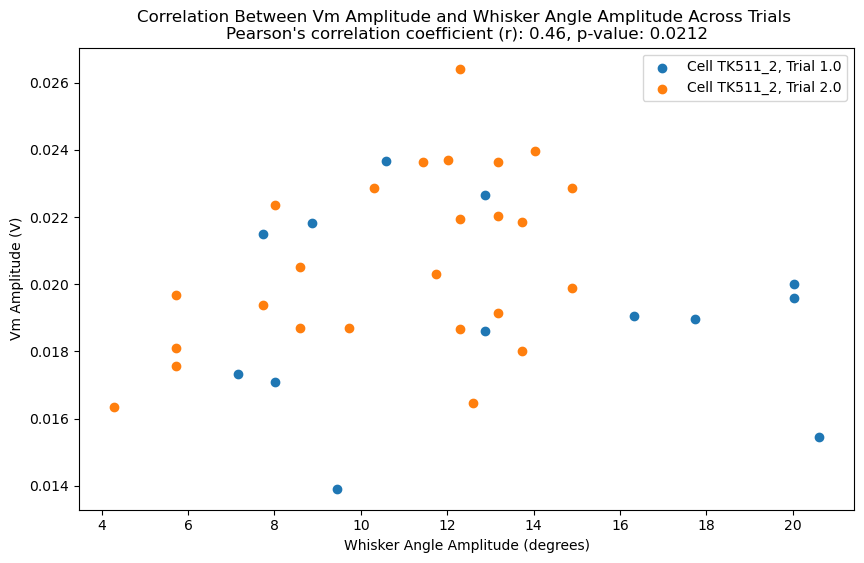

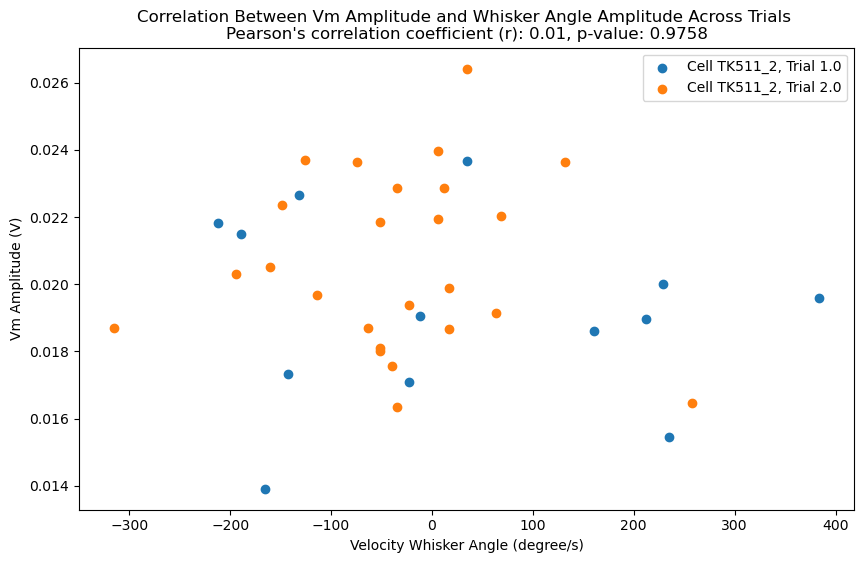

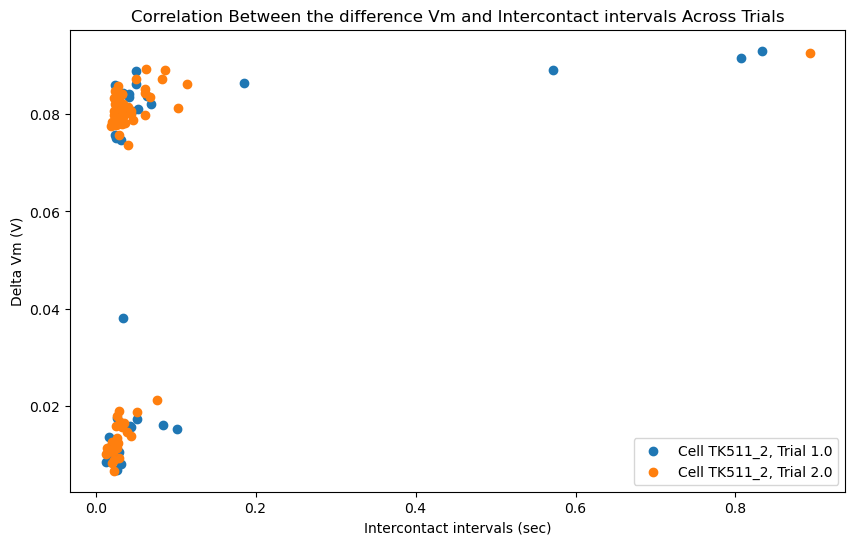

C:\Users\angel\AppData\Local\Temp\ipykernel_18876\3811741178.py:7: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


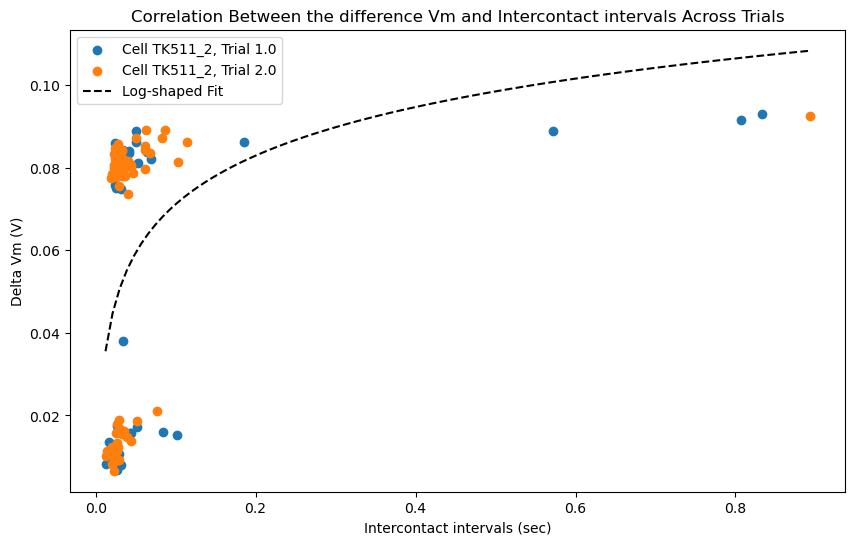

In [197]:
print(data_df_subset[data_df_subset.Cell_ID == 'TK511_2'].Cell_Type)
VmVsWhiskerAngle('TK511_2')
VmVsWhiskerVelocity('TK511_2')
deltaVmVsICI('TK511_2')
deltaVmVsICI3('TK511_2')

586    PV
587    PV
Name: Cell_Type, dtype: object
586    1.0
587    2.0
Name: Sweep_Counter, dtype: float64


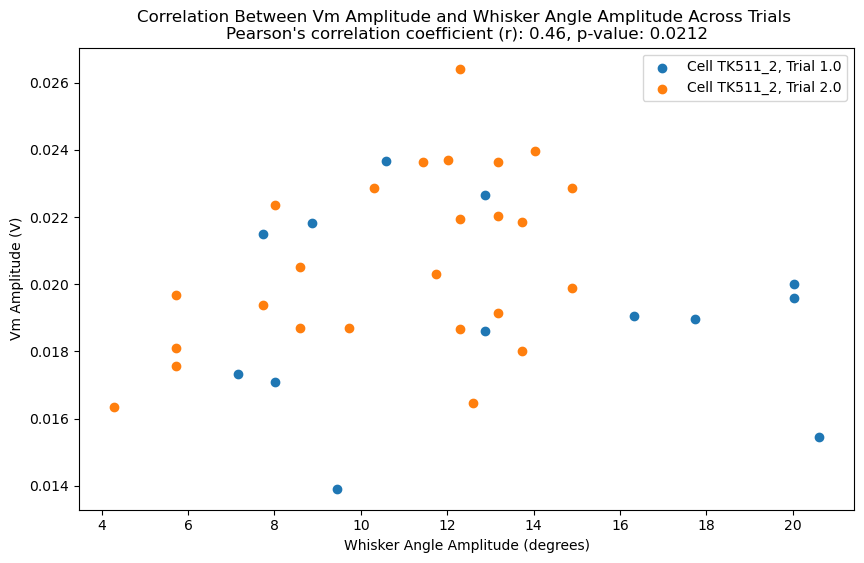

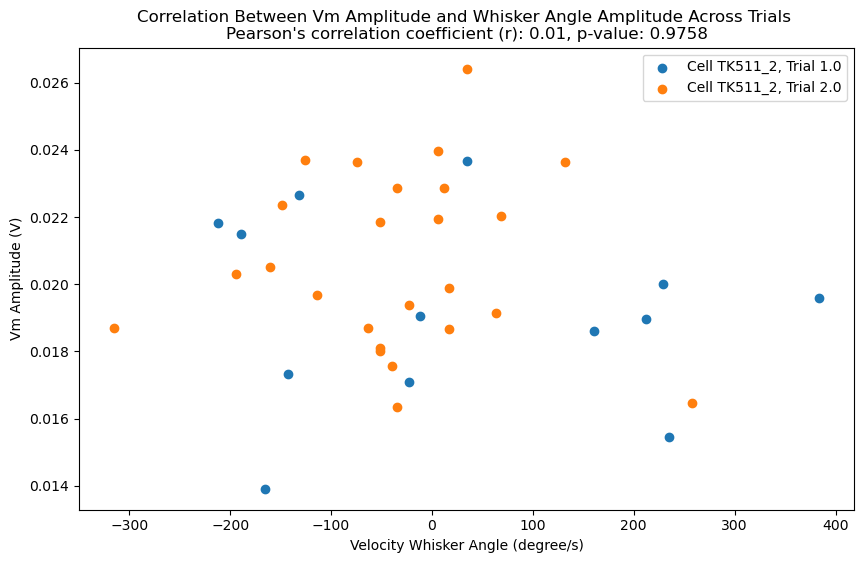

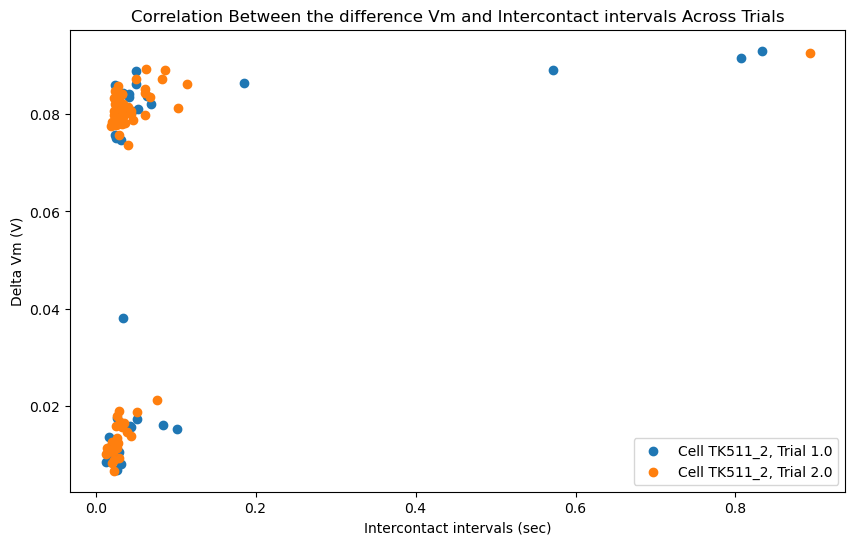

C:\Users\angel\AppData\Local\Temp\ipykernel_18876\3811741178.py:7: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


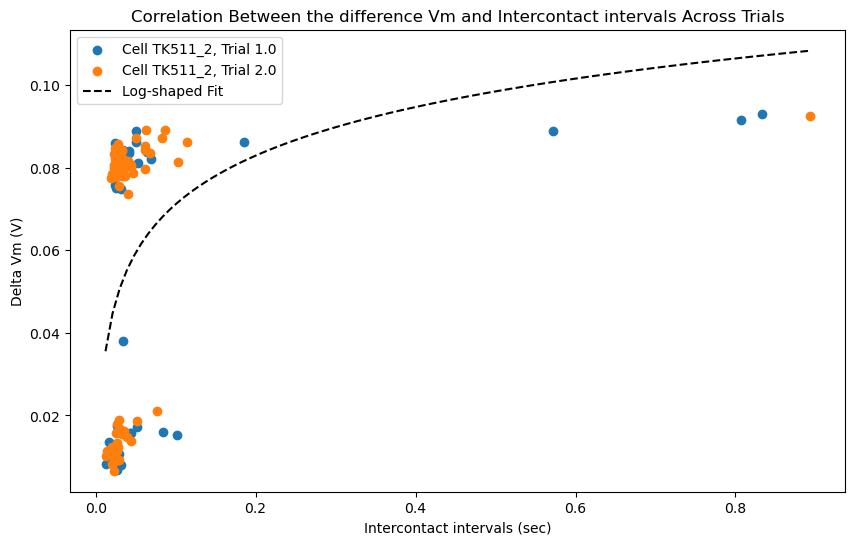

In [198]:
print(data_df_subset[data_df_subset.Cell_ID == 'TK511_2'].Cell_Type)
VmVsWhiskerAngle('TK511_2')
VmVsWhiskerVelocity('TK511_2')
deltaVmVsICI('TK511_2')
deltaVmVsICI3('TK511_2')

461    PV
462    PV
Name: Cell_Type, dtype: object
461    1.0
462    2.0
Name: Sweep_Counter, dtype: float64


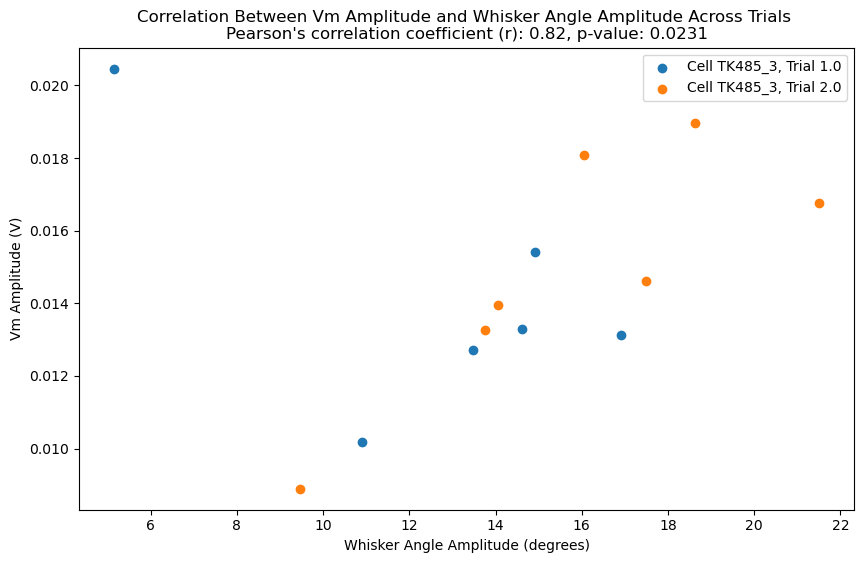

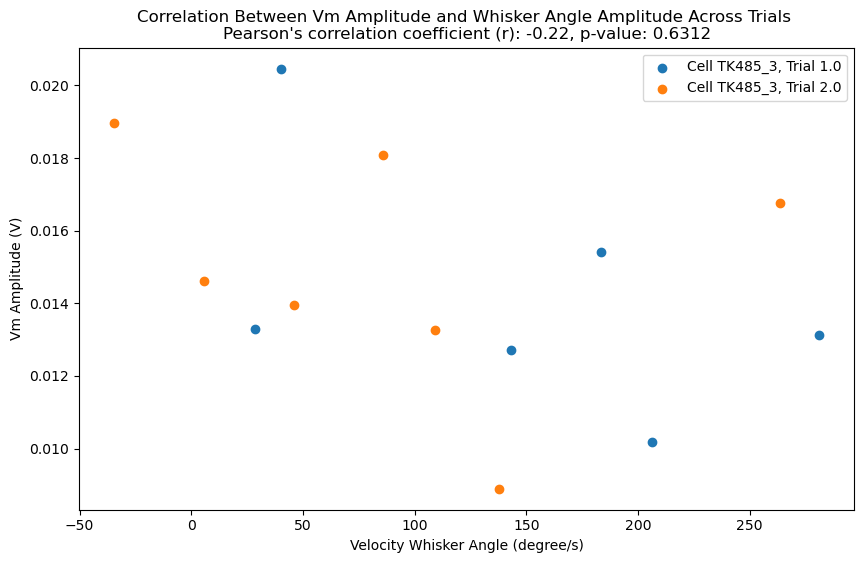

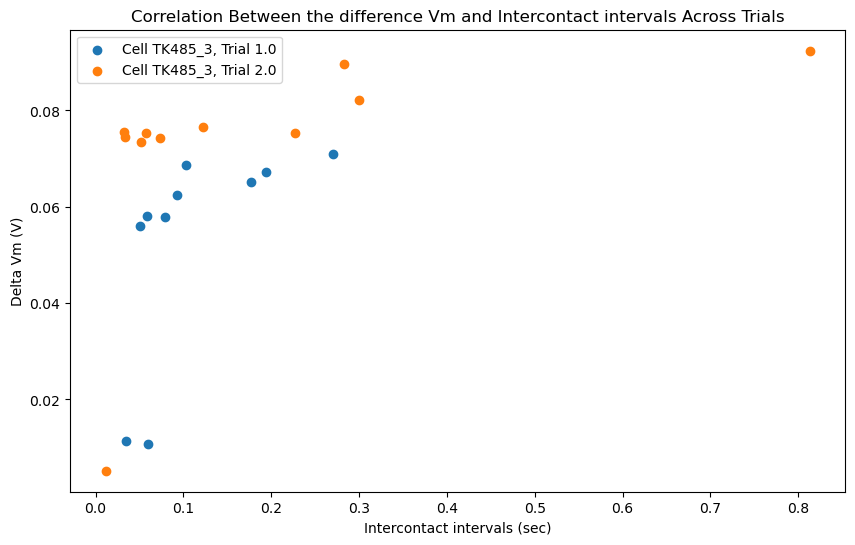

C:\Users\angel\AppData\Local\Temp\ipykernel_18876\3811741178.py:7: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


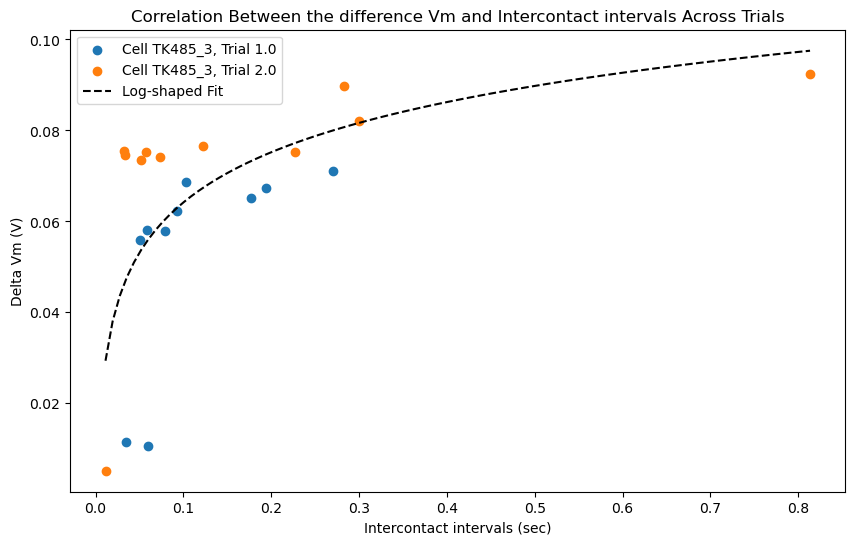

In [199]:
print(data_df_subset[data_df_subset.Cell_ID == 'TK485_3'].Cell_Type)
VmVsWhiskerAngle('TK485_3')
VmVsWhiskerVelocity('TK485_3')
deltaVmVsICI('TK485_3')
deltaVmVsICI3('TK485_3')

print(data_df_subset[data_df_subset.Cell_ID == 'TK480_3'].Cell_Type)
VmVsWhiskerAngle('TK480_3')
VmVsWhiskerVelocity('TK480_3')
deltaVmVsICI('TK480_3')
deltaVmVsICI3('TK480_3')

print(data_df_subset[data_df_subset.Cell_ID == 'TK502_1'].Cell_Type)
VmVsWhiskerAngle('TK502_1')
VmVsWhiskerVelocity('TK502_1')
deltaVmVsICI('TK502_1')
deltaVmVsICI3('TK502_1')

In [187]:
print((data_df_subset[data_df_subset.Cell_Type == 'PV'].Cell_ID).unique())

['TK326_2' 'TK364_1' 'TK407_1' 'TK412_1' 'TK450_1' 'TK478_1' 'TK479_1'
 'TK479_2' 'TK479_3' 'TK480_1' 'TK480_3' 'TK485_3' 'TK491_1' 'TK491_3'
 'TK502_1' 'TK502_2' 'TK502_3' 'TK509_2' 'TK511_1' 'TK511_2' 'TK512_1'
 'TK512_2']


In [116]:
whisker = data_df['Sweep_WhiskerAngle'][100]

In [ ]:
mrche pas : TK479_1,TK326_2

In [34]:
#angle at the beginning

In [35]:
#plt.plot(np.arange[1,2001],whisker)

In [36]:
#le temps=longueur du vector/sampling rate

In [38]:
good_event_times = []
min_iti=0.2

if type(event_times[0]) == np.float64:
    good_event_times.append(event_times)
else:
    for i in np.arange(len(event_times)):
        if i == len(event_times)-1:
            good_event_times.append(event_times[i])
        elif event_times[i+1][0] - event_times[i][1] > min_iti:
            good_event_times.append(event_times[i])